In [34]:
import sys
import os
import numpy as np 
import pandas as pd
import numpy.matlib


import matplotlib.pyplot as plt
from scipy.integrate import odeint

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

import torch
import cvxpy as cp
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

## Generate data points $X$

In [35]:
# Set the random seed for reproducibility
np.random.seed(42)

# Function to generate clustered data
def generate_clusters(N):
    # Number of points per cluster
    points_per_cluster = N
    
    # Define the cluster centers
    # cluster_centers = [(1, 1), (5, 5), (9, 1)]
    cluster_centers = [(1, 1)]
    
    # Variance of clusters
    # cluster_variance = [0.5, 0.3, 0.4]
    cluster_variance = [0.7]
    
    # Initialize an empty array for all points
    X = np.empty((0, 2), dtype=float)
    
    # Generating points around each cluster center
    for center, variance in zip(cluster_centers, cluster_variance):
        # Generate points from a multivariate normal distribution
        points = np.random.multivariate_normal(mean=center, cov=[[variance, 0], [0, variance]], size=points_per_cluster)
        X = np.vstack((X, points))
    
    return X

# Generate the data
N = 100
X_init = generate_clusters(N)

## Initialize cluster centers

In [36]:
m = 1
Y = np.mean(X_init,axis = 0)*np.ones((m,2))

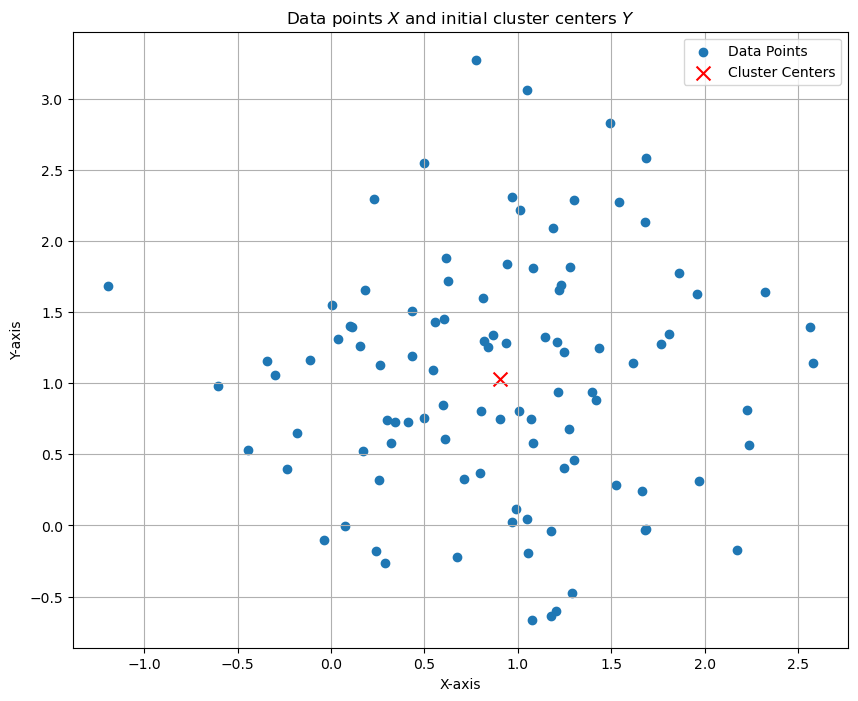

In [37]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X_init[:, 0], X_init[:, 1], label='Data Points')
plt.scatter(Y[:, 0], Y[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title("Data points $X$ and initial cluster centers $Y$")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show()  

In [38]:
# Dynamics function
def dynamics(t, X):
    a = 0.02
    b = 0.15
    X = X.reshape(-1,2)  # Reshape flat array to Nx2
    Xdot = a * X + b * np.sin(X)  # Dynamics equation
    return Xdot.flatten()  # Return as flat array for solver

# Parameters
time_span = [0, 10]  # Time span for the simulation

# Solve the ODE
solution = solve_ivp(dynamics, time_span, X_init.flatten(), dense_output=True)

# Create time points to evaluate the solution
t = np.linspace(time_span[0], time_span[1], 100)

# Evaluate solution at each time point
X = solution.sol(t)
X = X.reshape(-1,1,len(t))
X = X.reshape(N*m,2,len(t))

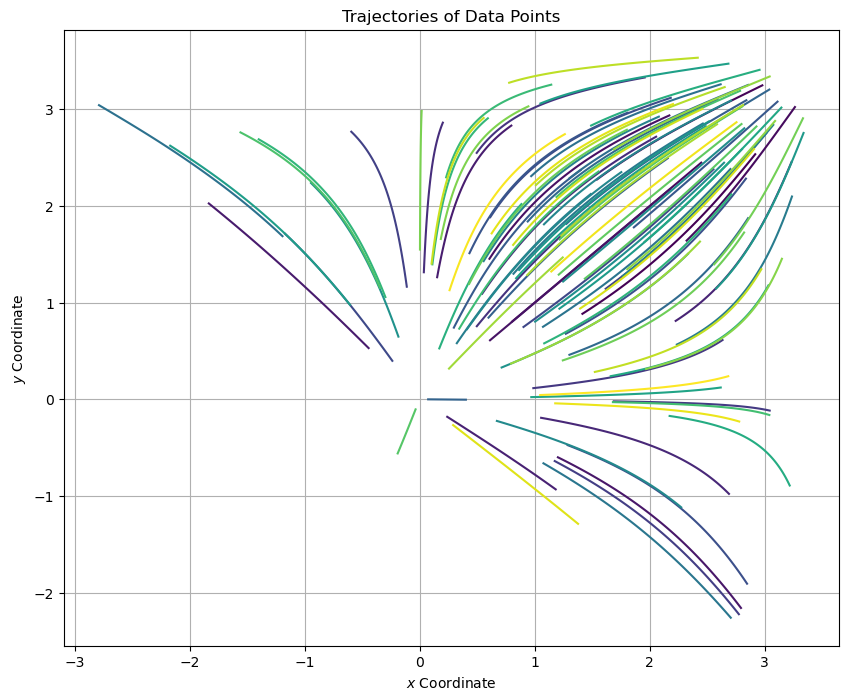

In [39]:
# Plotting
plt.figure(figsize=(10, 8))  # Set the size of the plot

colors = plt.cm.viridis(np.linspace(0, 1, m*N))  # Use a colormap for different trajectories

for n in range(X.shape[0]):
    plt.plot(X[n, 0, :], X[n, 1, :], color=colors[n],)  # Plot each trajectory with a different color

# Add decorations
plt.title('Trajectories of Data Points')  # Title of the plot
plt.xlabel('$x$ Coordinate')  # X-axis label
plt.ylabel('$y$ Coordinate')  # Y-axis label
plt.grid(True)  # Add a grid for easier visualization of scale and position
plt.savefig('data_dynamics.png', dpi=300, bbox_inches='tight')  # Saving the figure
plt.show()

In [40]:
def cluster_beta(X_init,Y_init,m,beta,pert):
    N = np.shape(X_init)[0]
    Y_init += pert * (np.arange(m)+1).reshape(-1,1) * np.ones((m,2))
    X_expanded = np.expand_dims(X_init, 1)  # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y_init, 0)       # Shape (1, m, 2)

    # Compute the squared differences, sum over the coordinate axis (axis=2), and take the square root
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    P_yx = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    P_xy = P_yx/(np.sum(P_yx, axis = 0).reshape(1,-1))
    Y_c = P_xy.T @ X_init
    return Y_c, P_yx, P_xy 

In [41]:
def clustering(X_init,m,pert,beta_final,alpha):
    beta = 0.01
    Y_init = np.mean(X_init,axis = 0)*np.ones((m,2))
    while beta <= beta_final:
        Y, P_yx, P_xy = cluster_beta(X_init,Y_init,m,beta,pert)
        beta *= alpha 
        Y_init = Y
        
    return Y, P_yx

In [42]:
def interpolate_data(data, t):

    # Initialize an empty list to hold interpolation functions for each data point
    interpolation_funcs = []

    # Iterate over each data point
    for i in range(data.shape[0]):  # Loop over 300 data points
        point_funcs = []
        for j in range(data.shape[1]):  # Loop over the 2 dimensions of each point
            # Create a cubic spline interpolation for the current data series
            cs = CubicSpline(t, data[i, j, :])
            point_funcs.append(cs)
        interpolation_funcs.append(point_funcs)
    
    # Return a function that can evaluate these interpolations at a new time
    def evaluate_at_new_time(new_t):
        # Evaluate each interpolation function at the new time
        interpolated_data = np.array([[func(new_t) for func in point] for point in interpolation_funcs])
        return interpolated_data

    return evaluate_at_new_time

## Frame by frame evaluation from $t_0$ to $t_f$

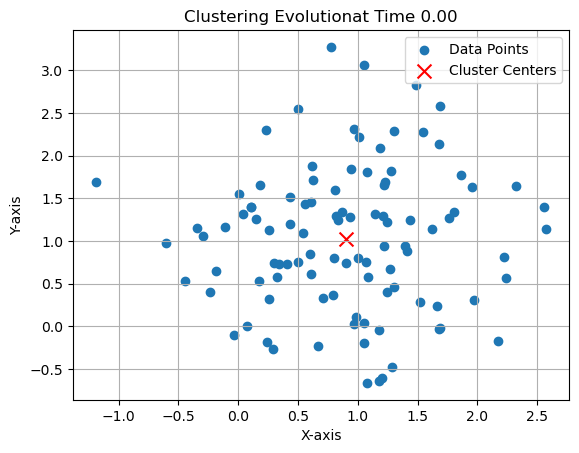

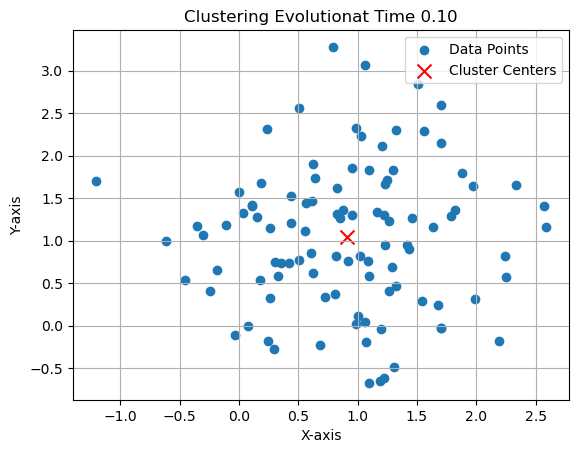

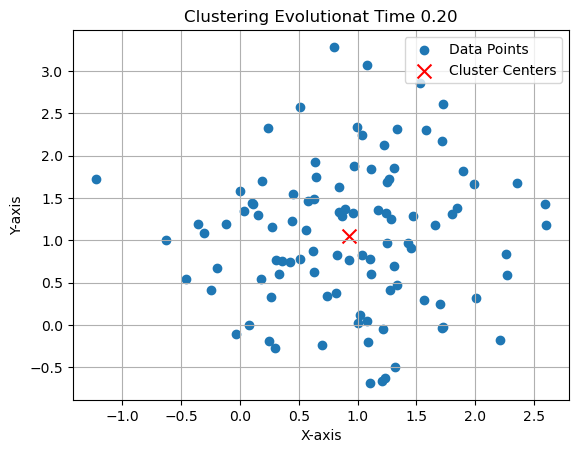

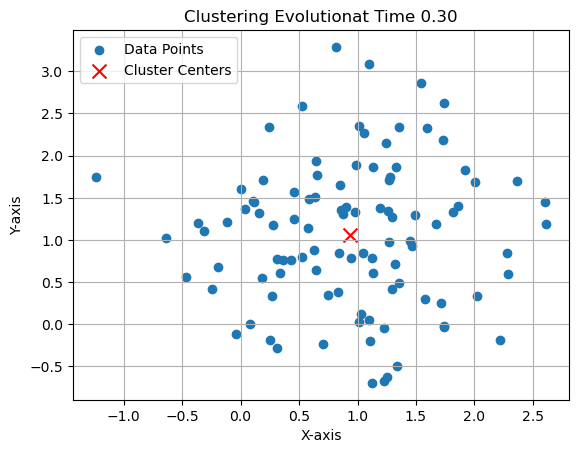

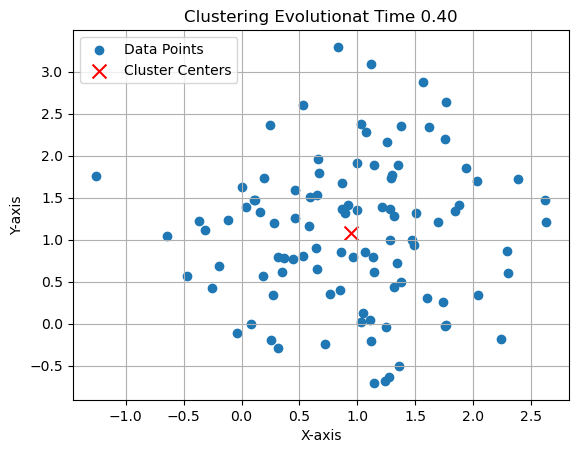

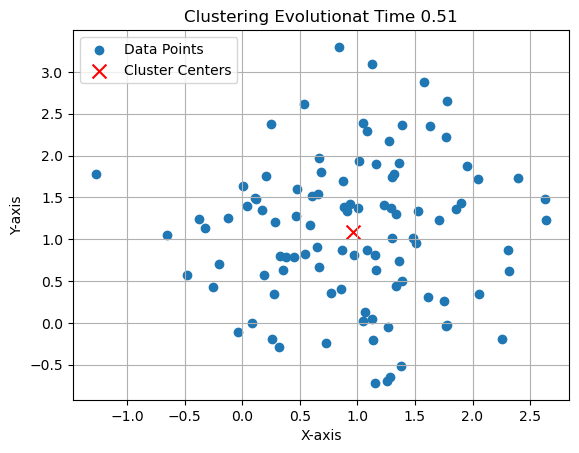

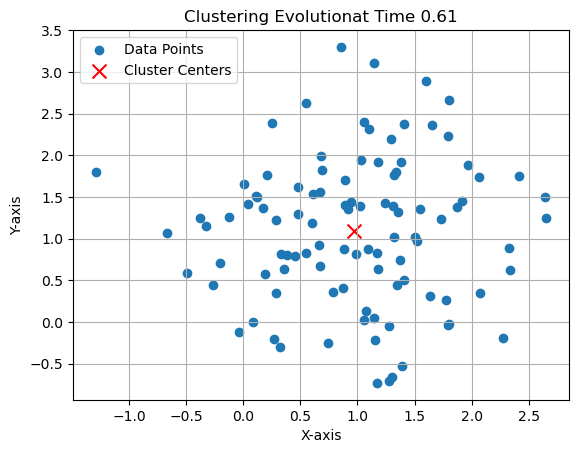

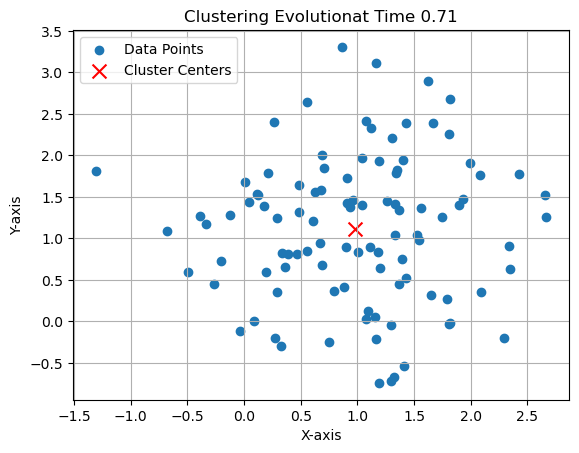

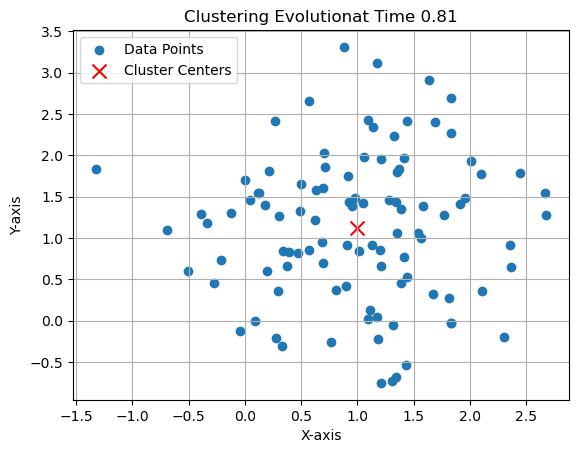

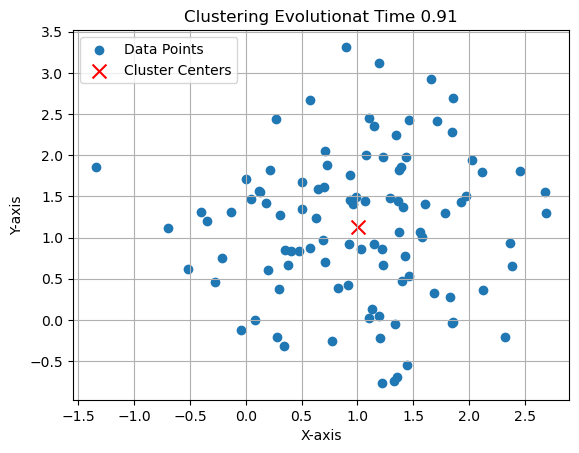

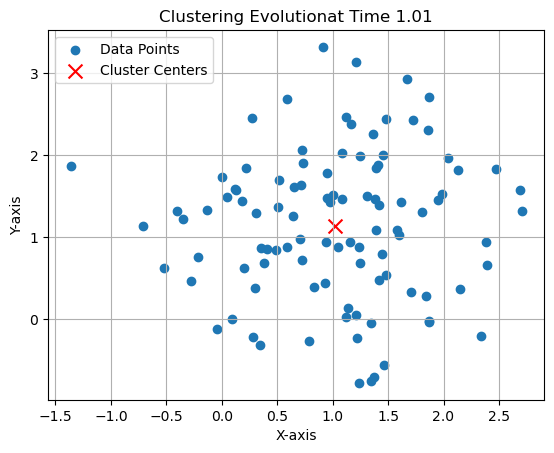

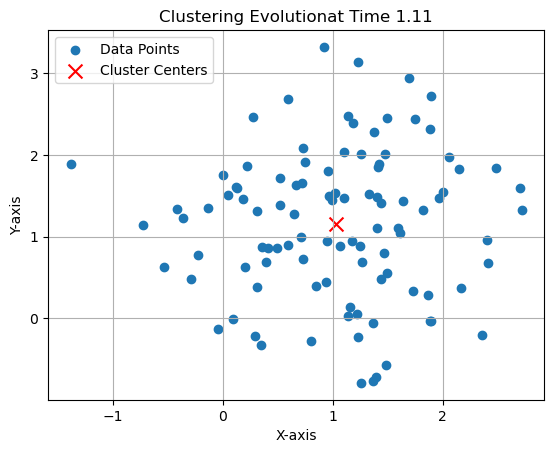

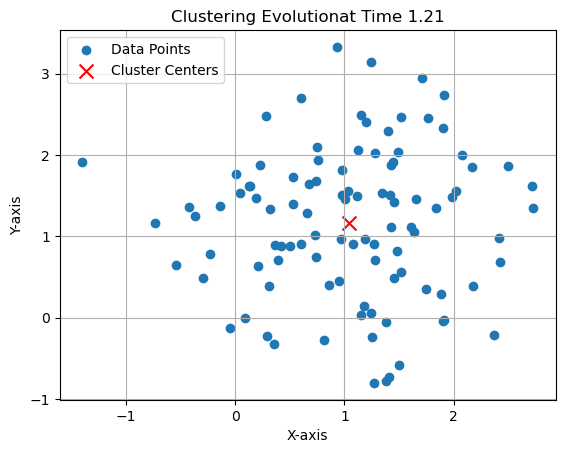

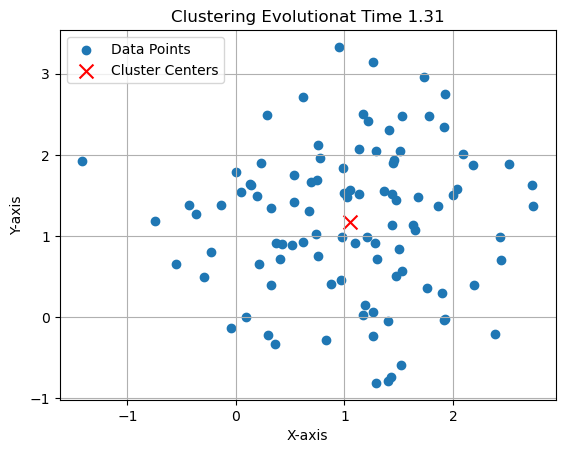

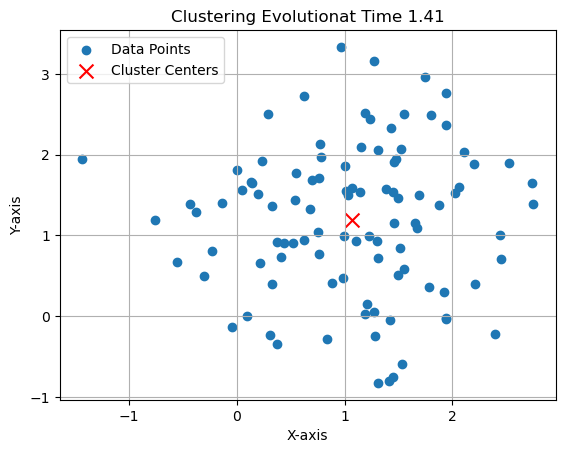

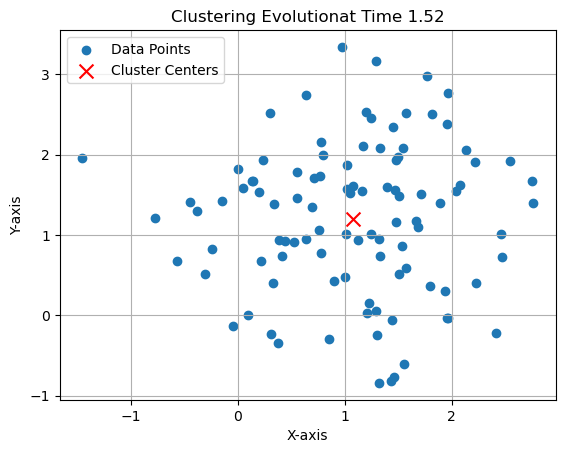

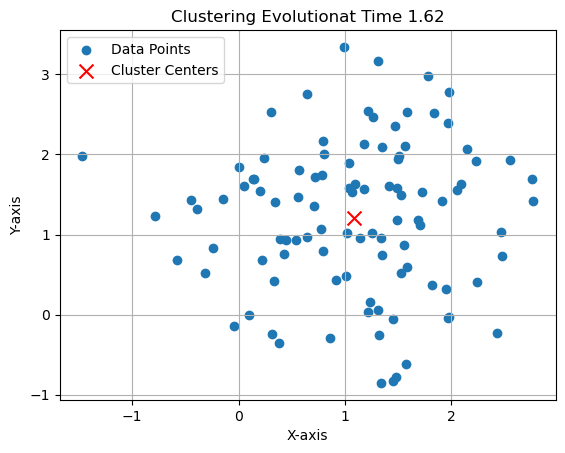

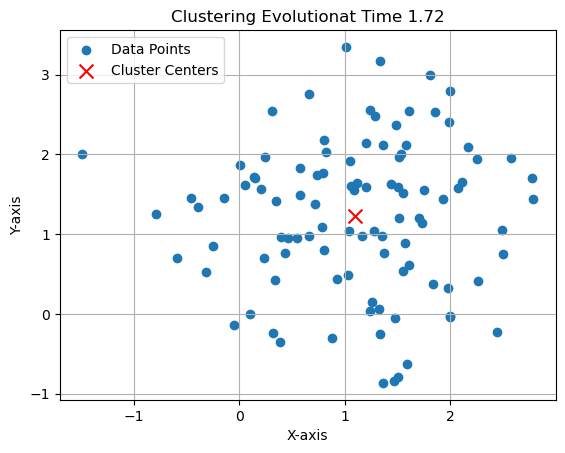

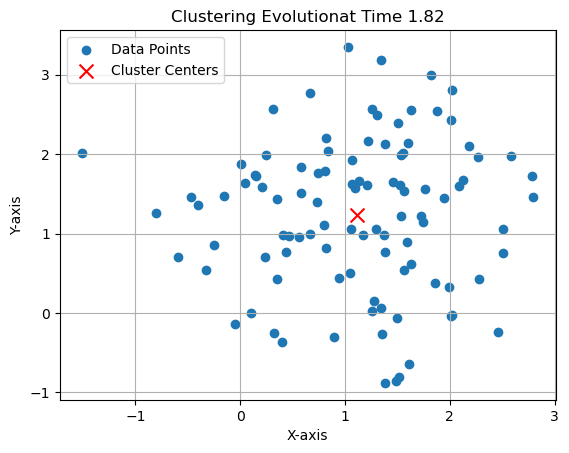

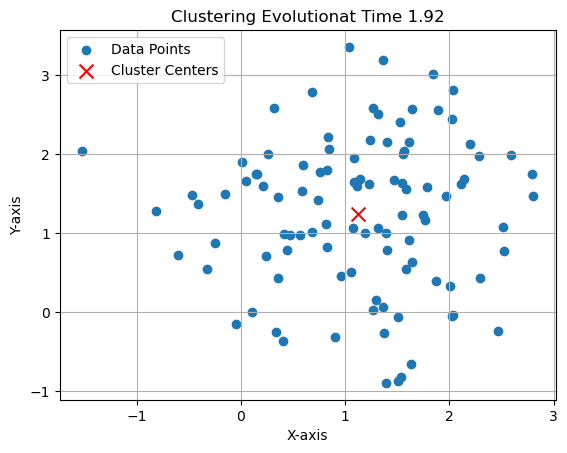

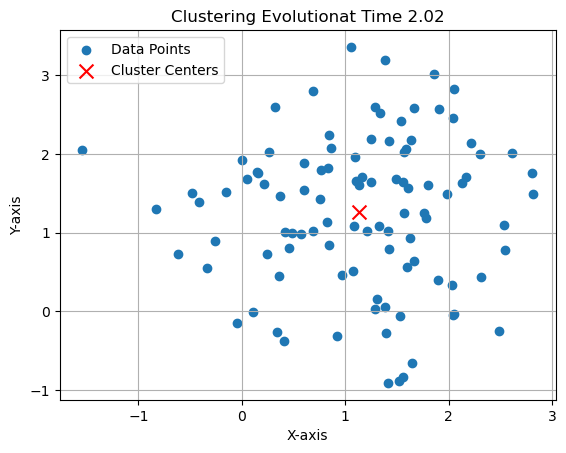

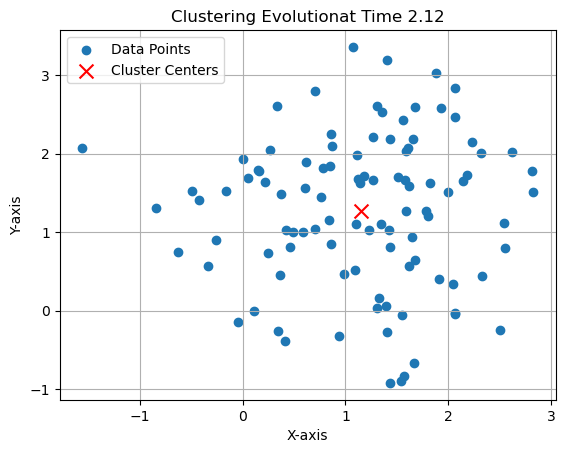

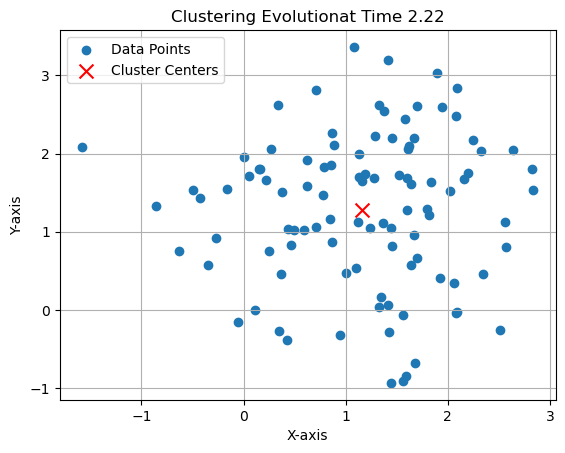

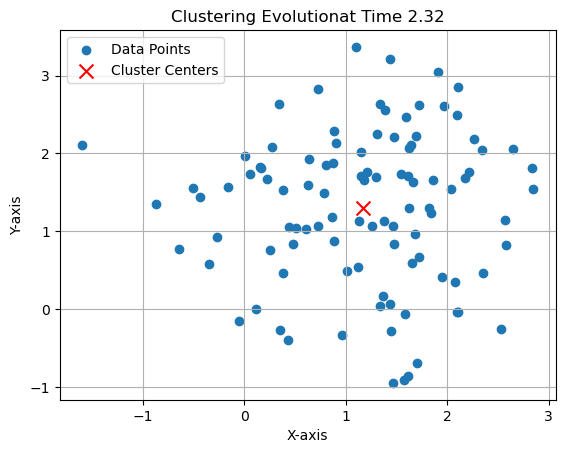

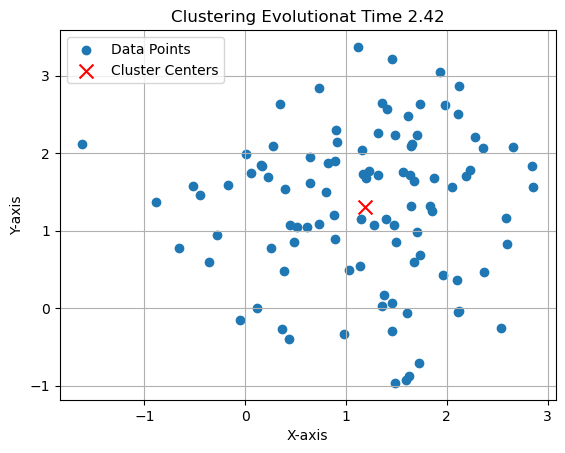

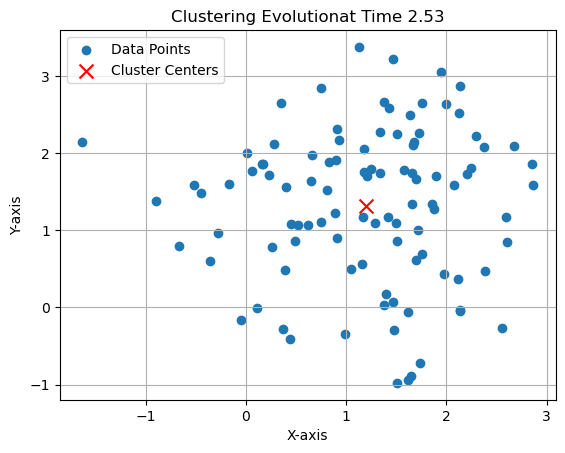

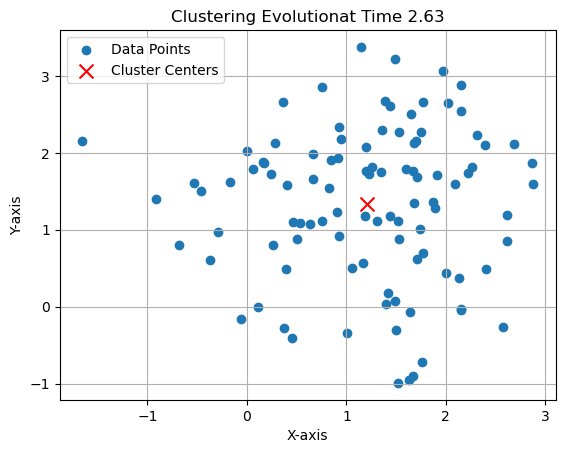

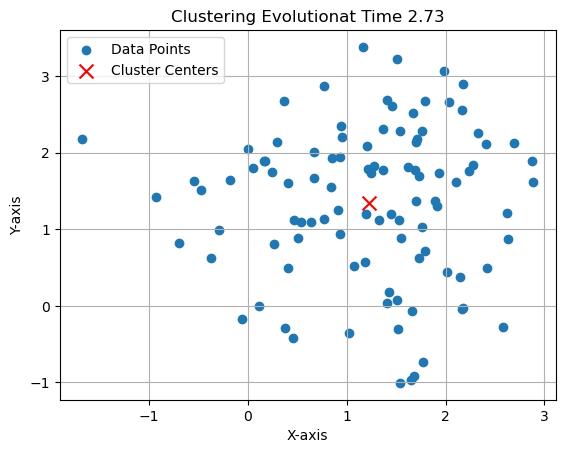

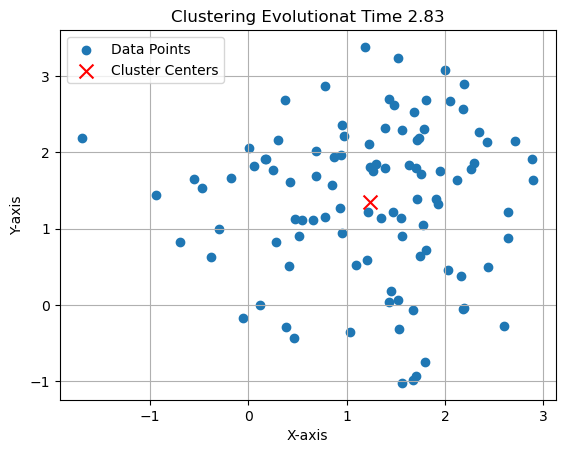

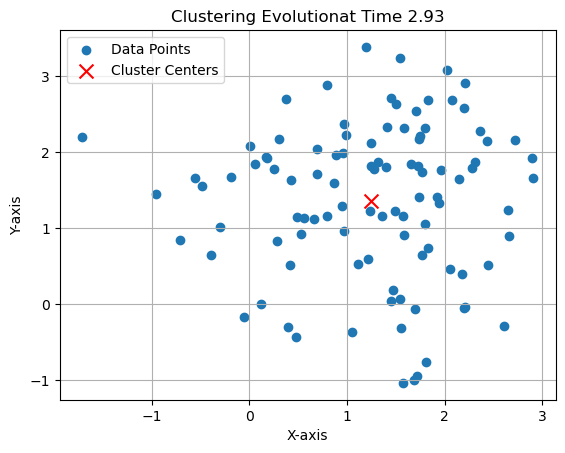

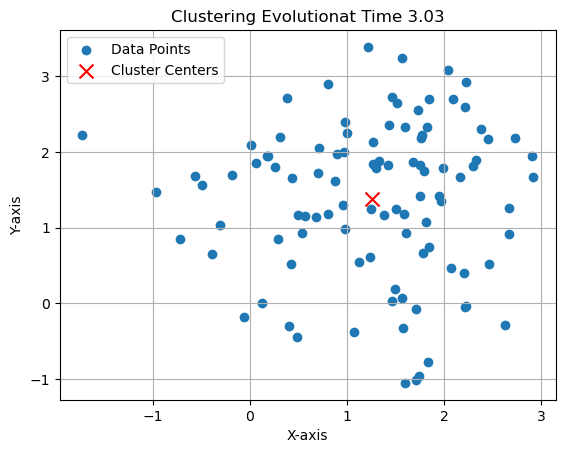

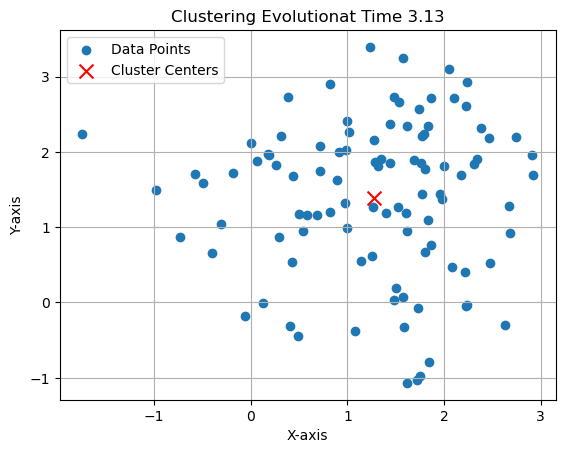

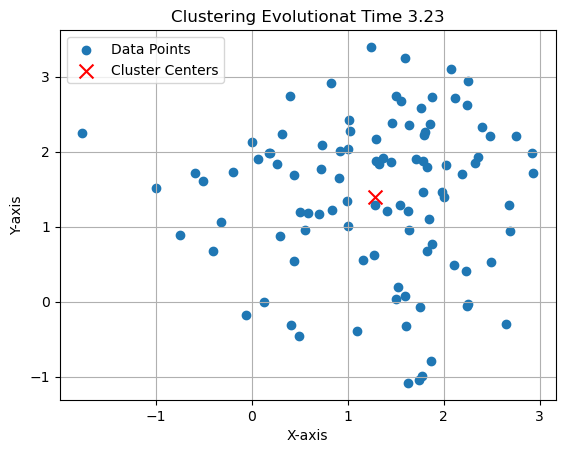

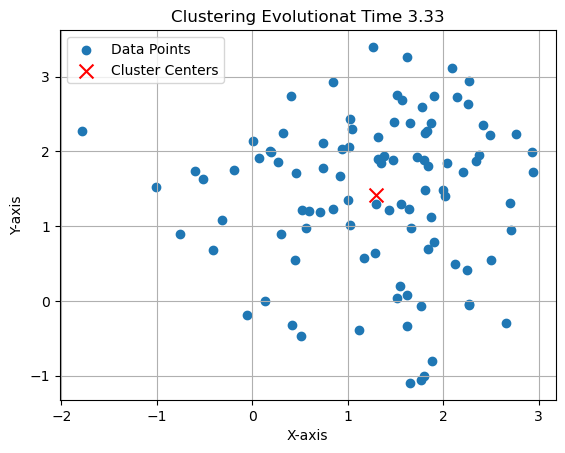

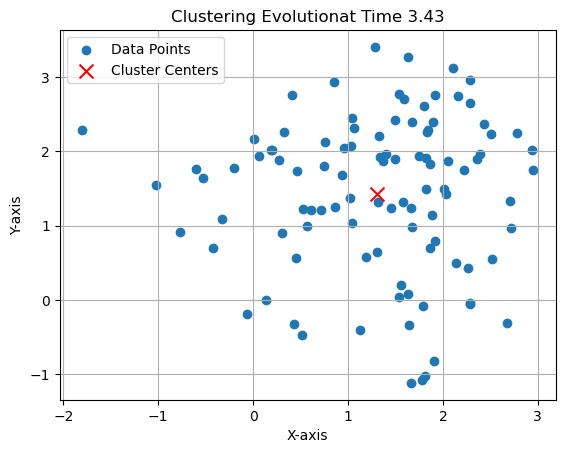

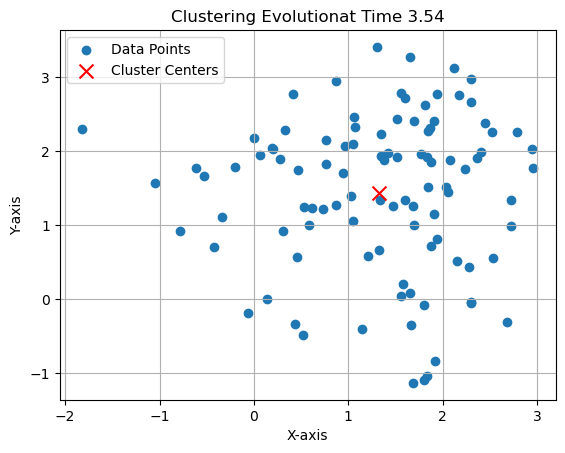

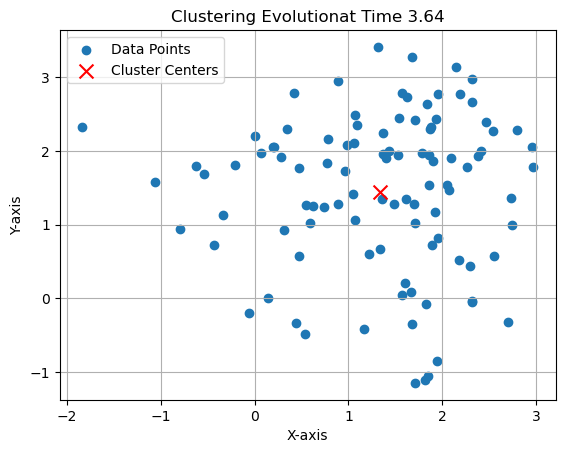

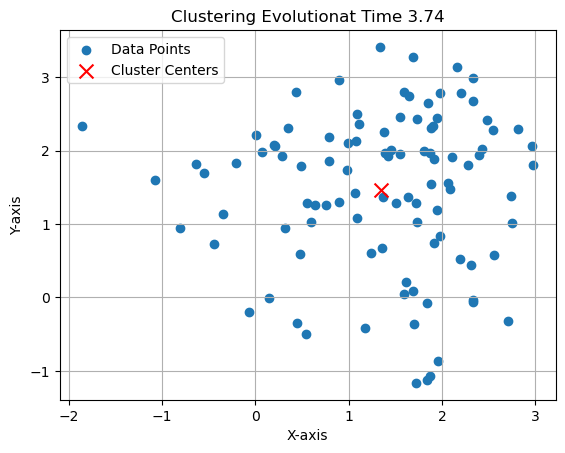

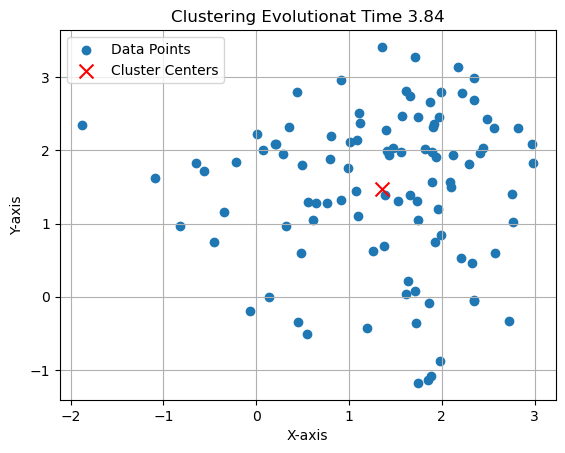

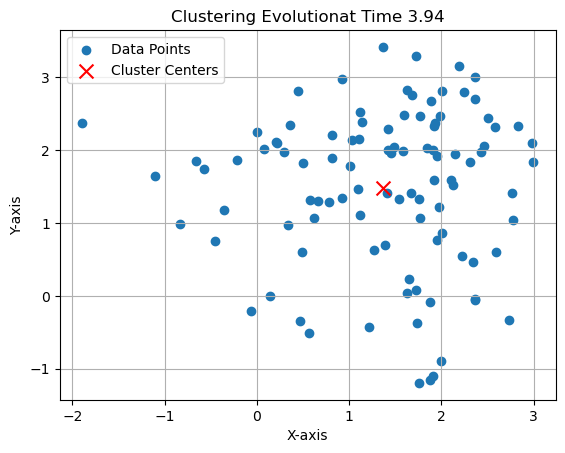

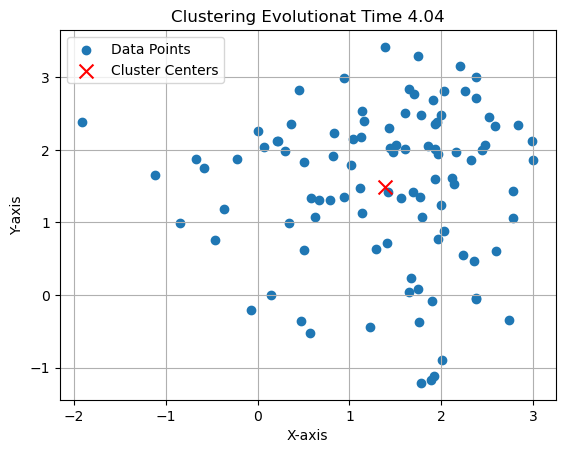

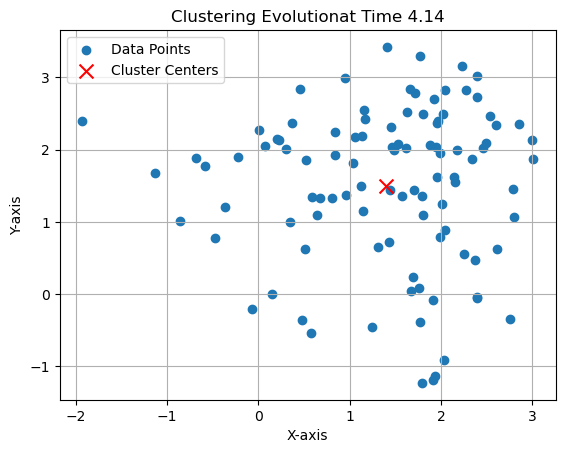

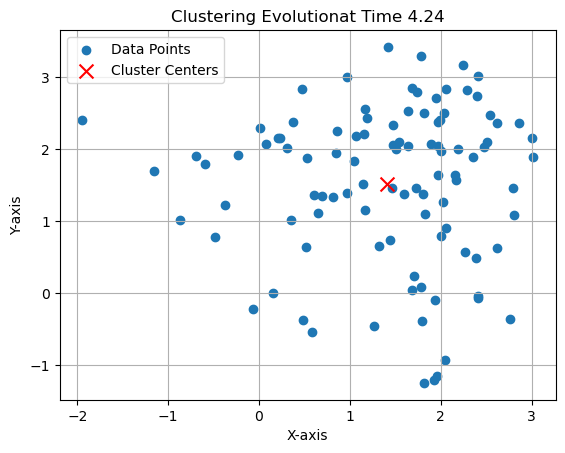

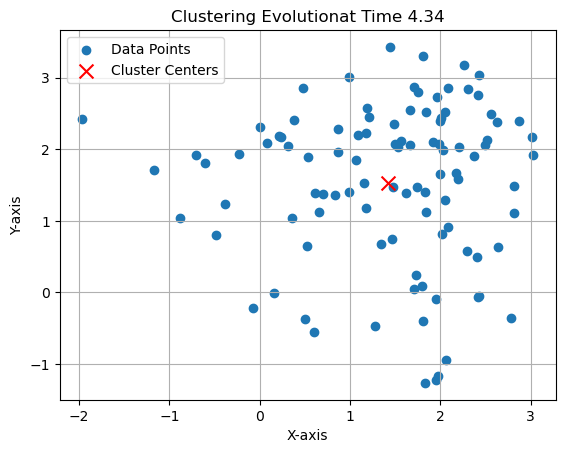

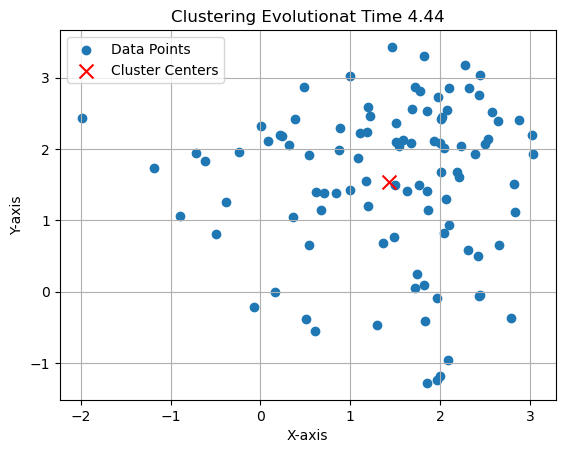

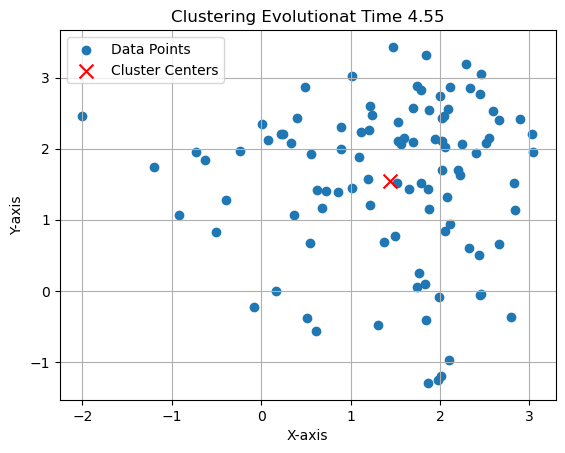

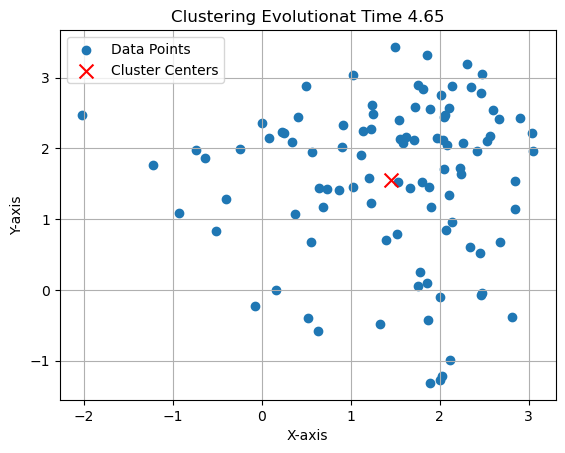

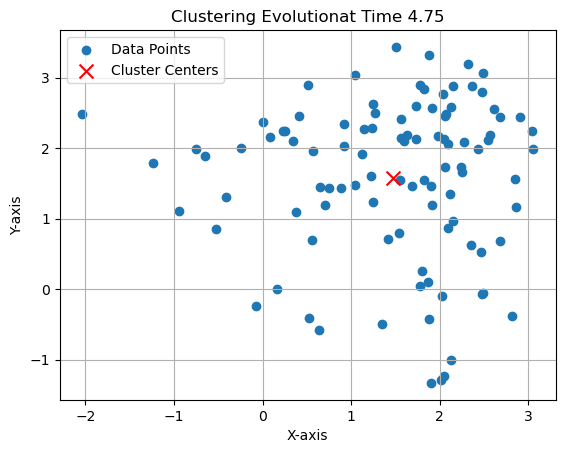

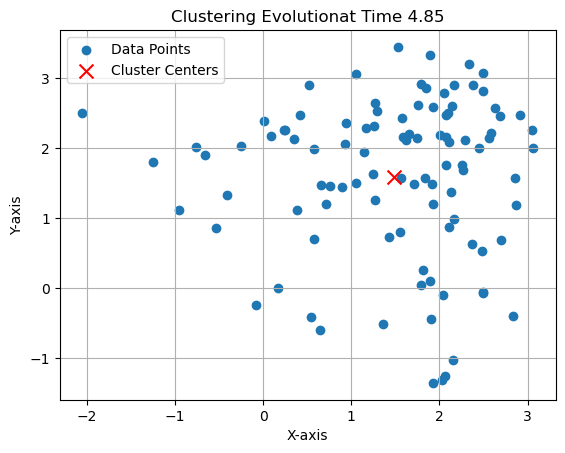

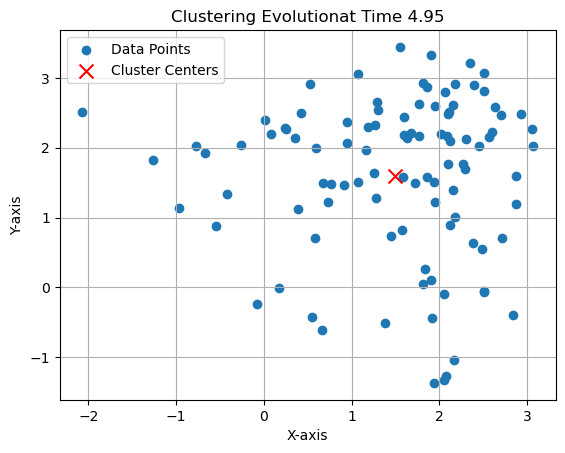

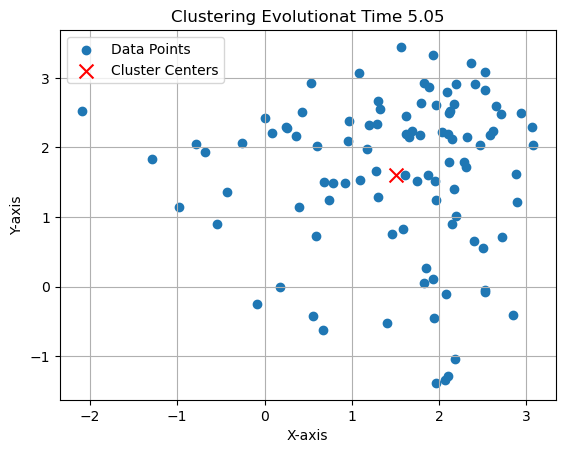

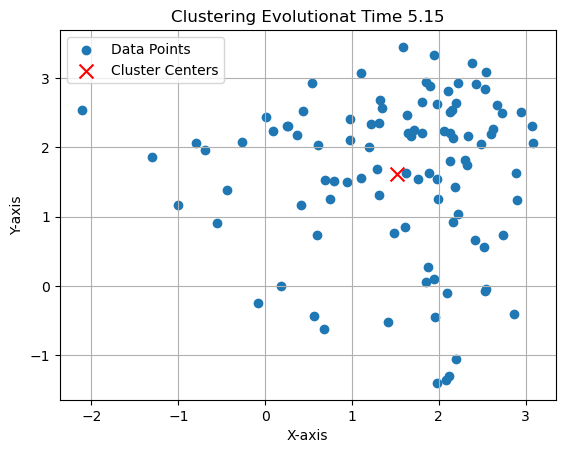

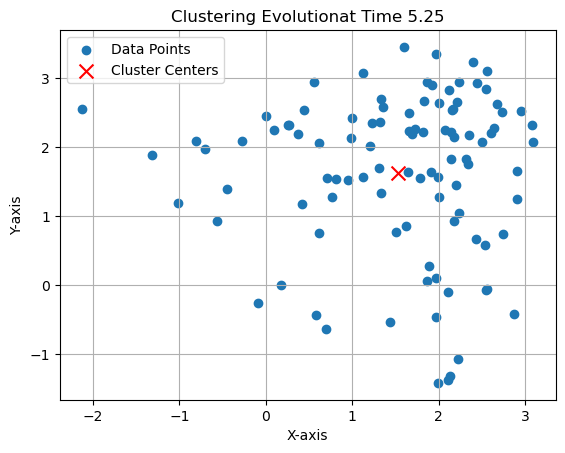

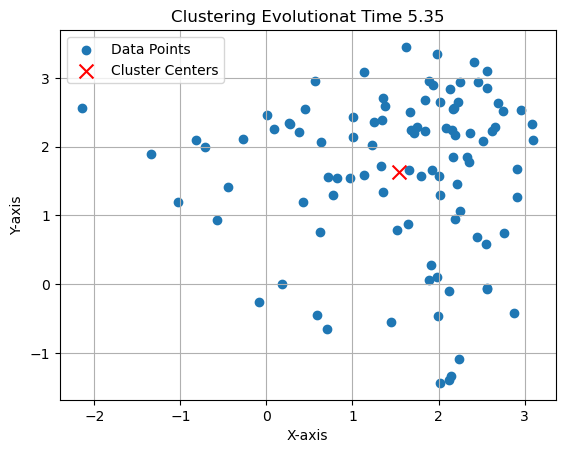

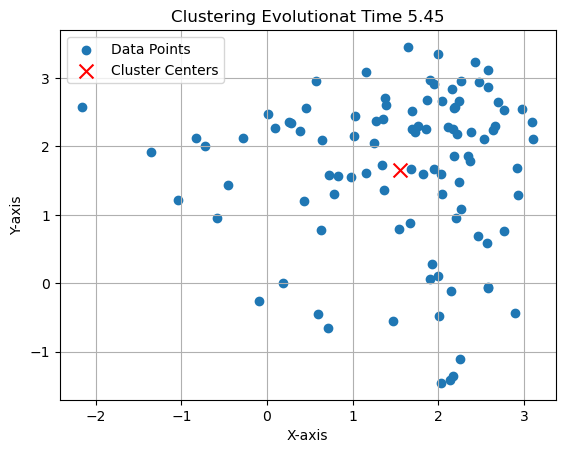

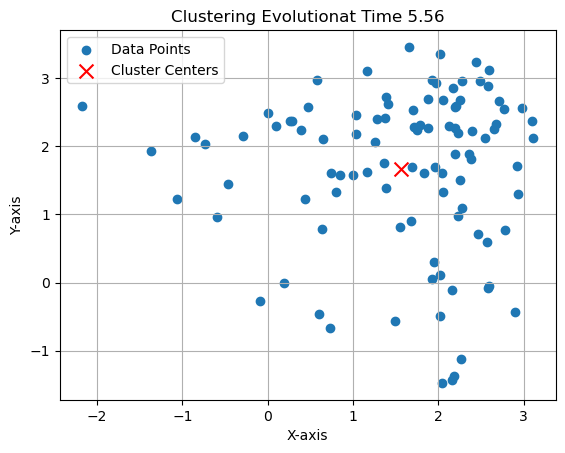

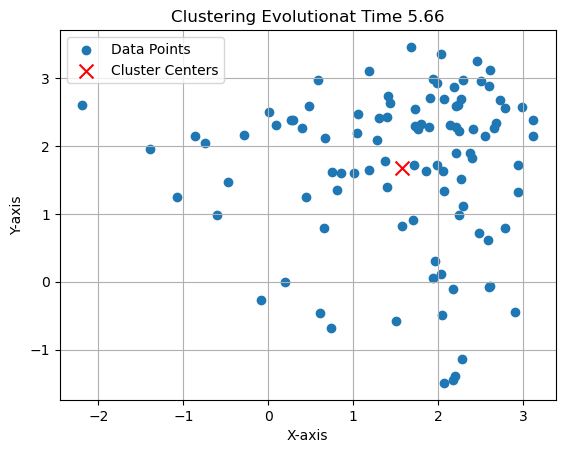

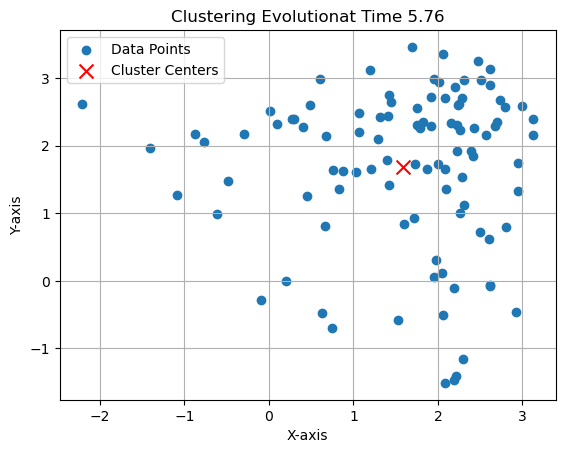

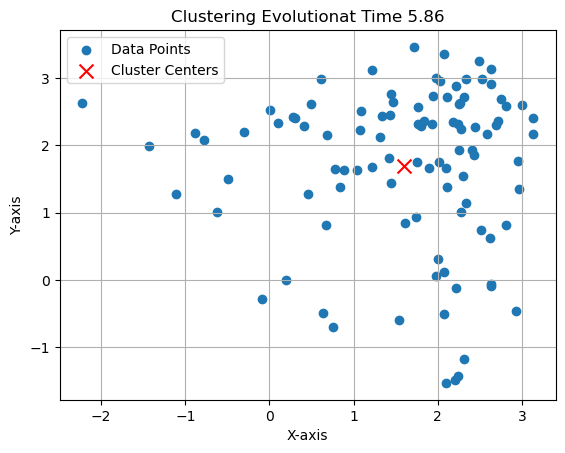

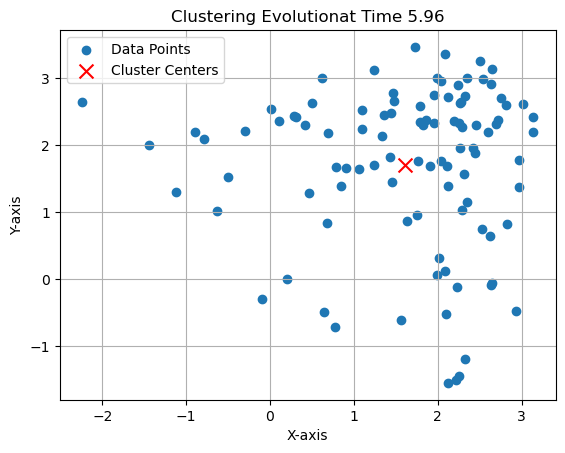

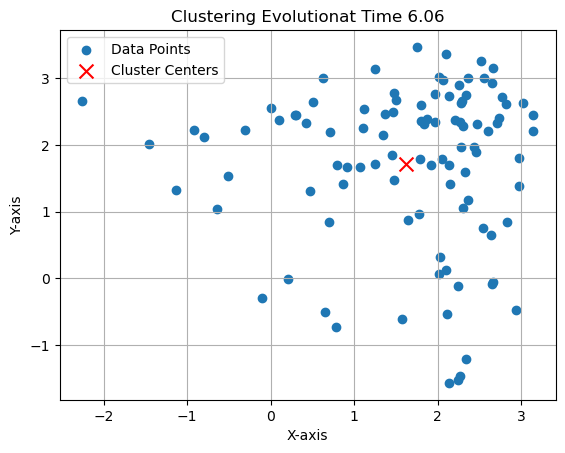

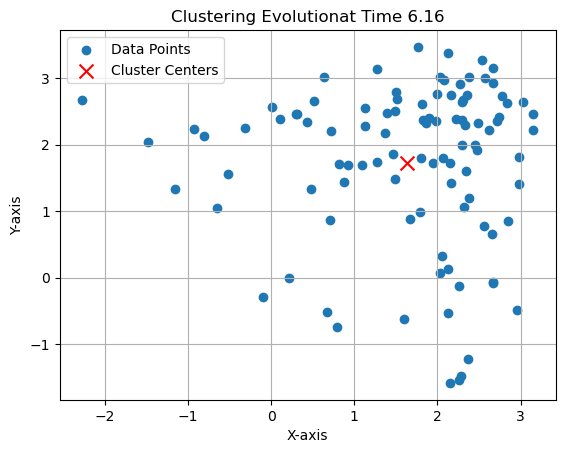

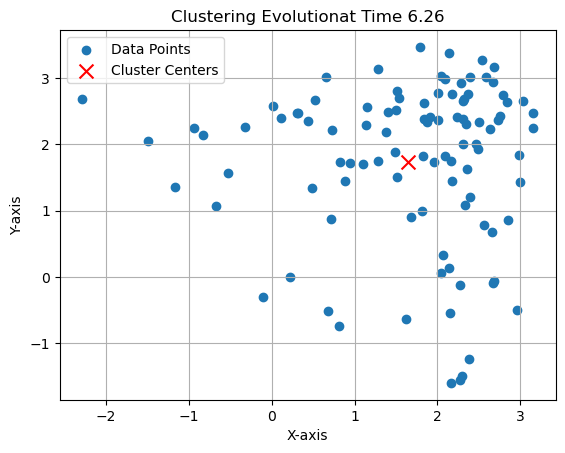

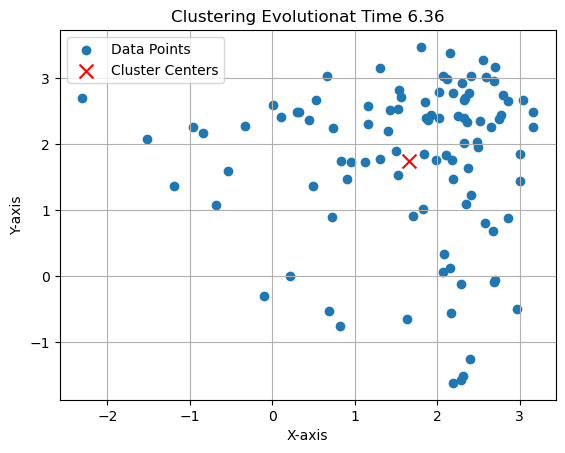

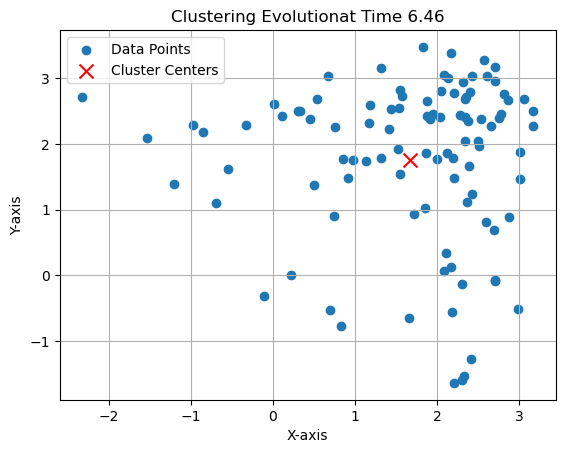

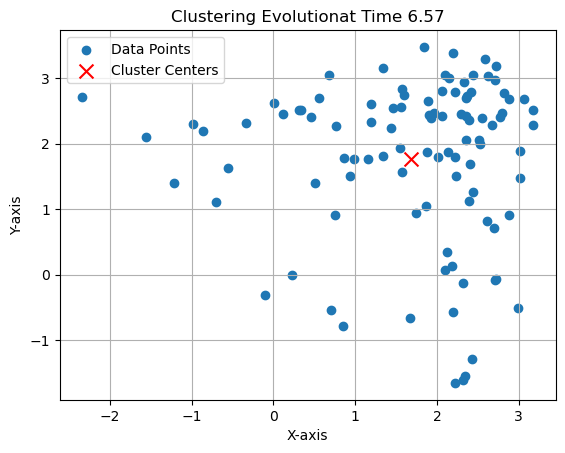

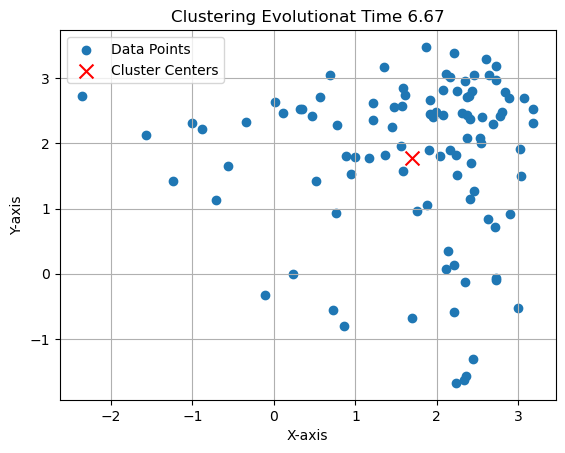

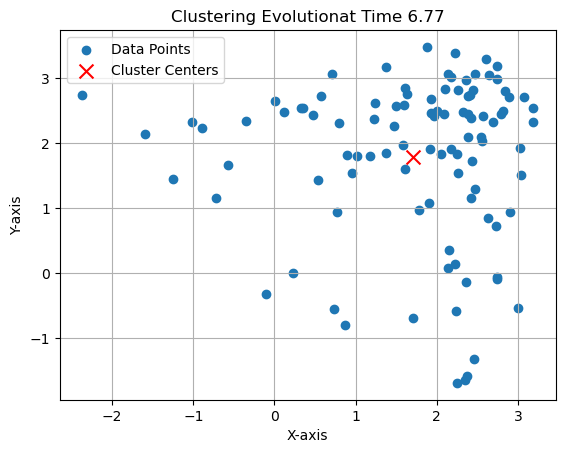

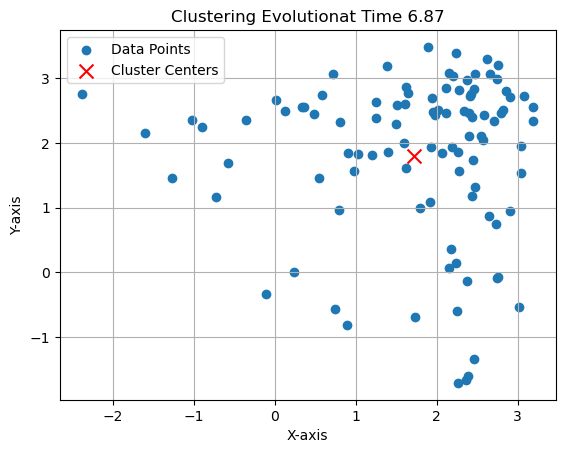

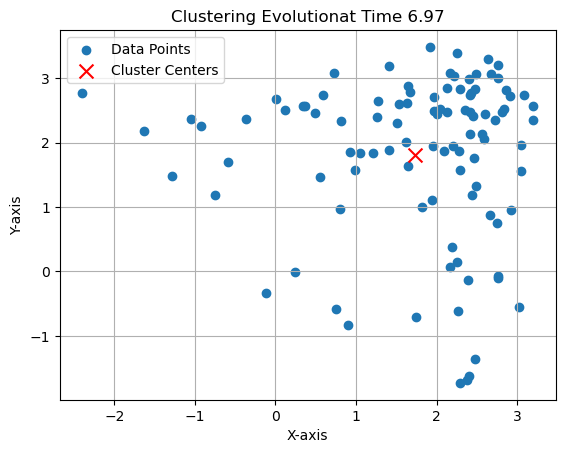

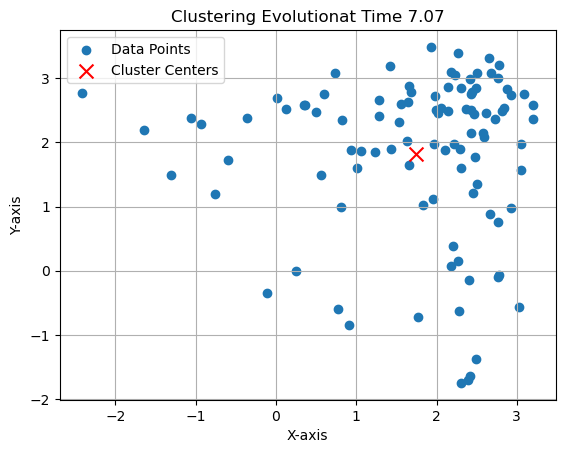

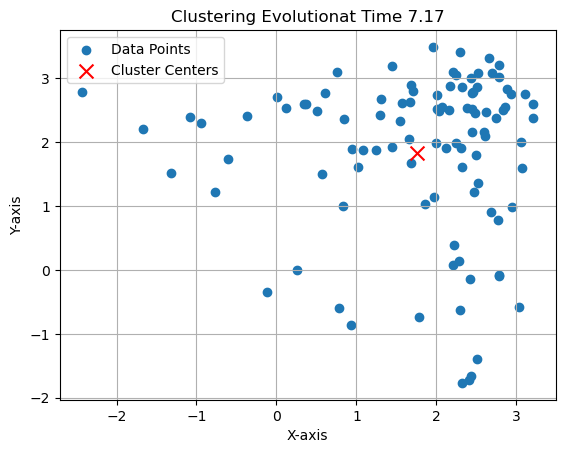

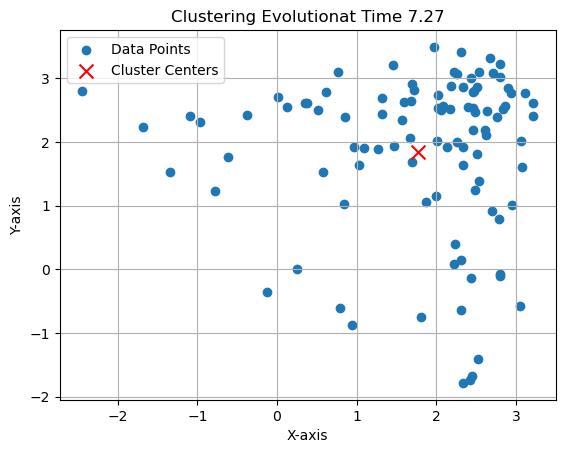

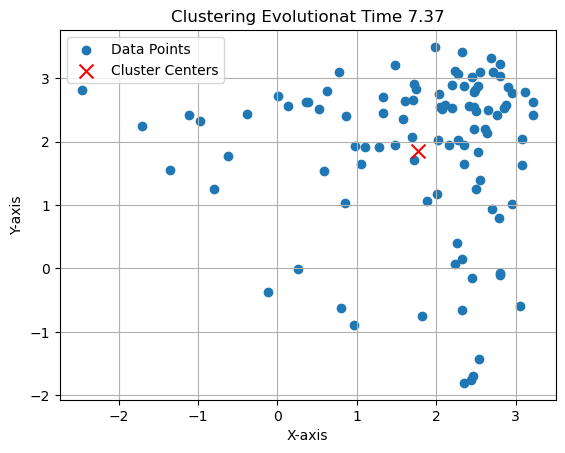

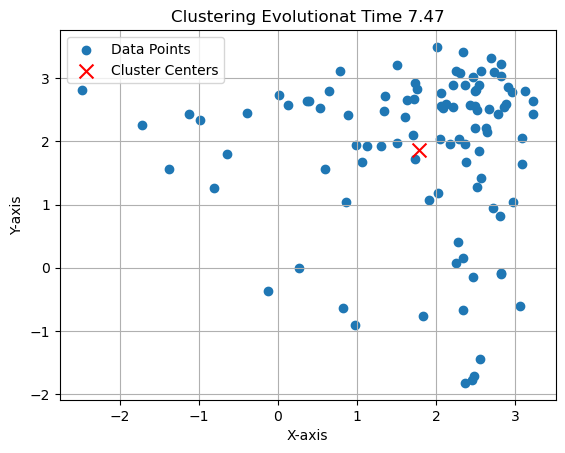

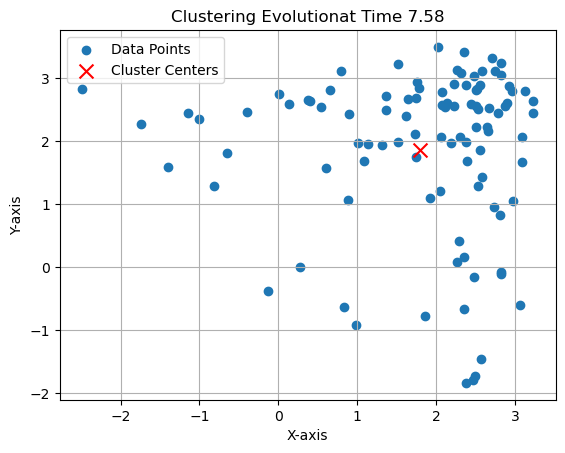

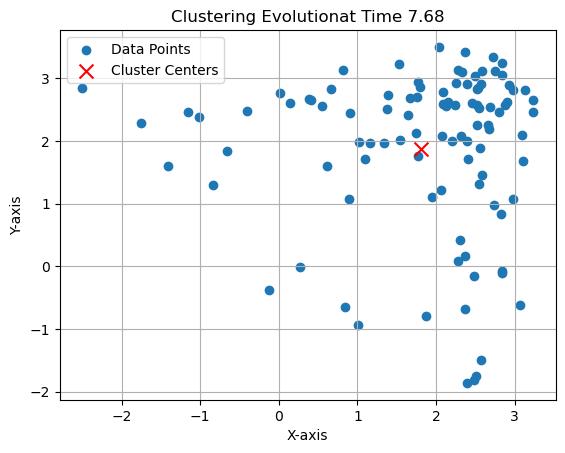

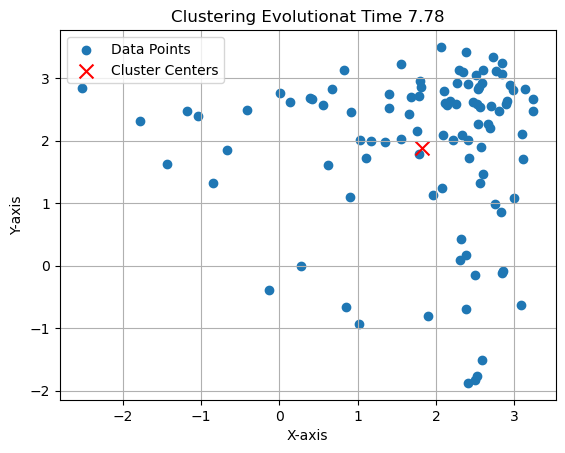

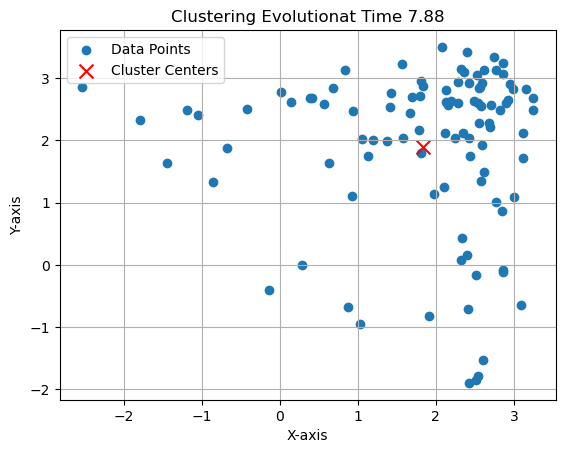

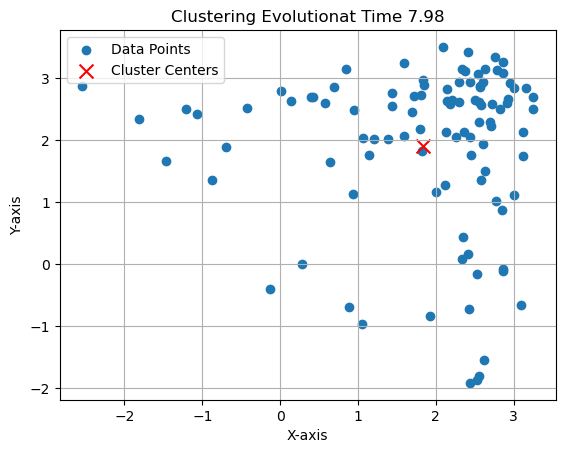

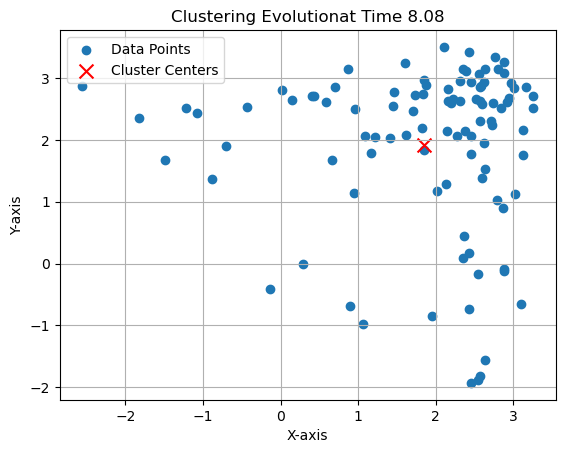

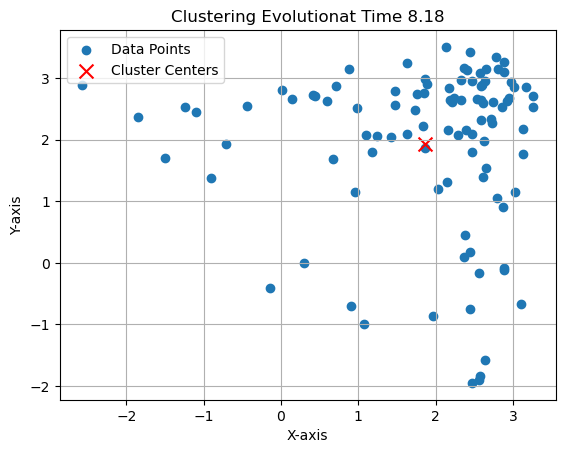

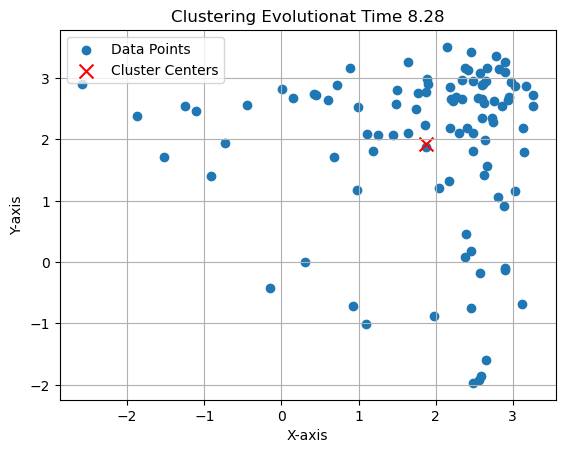

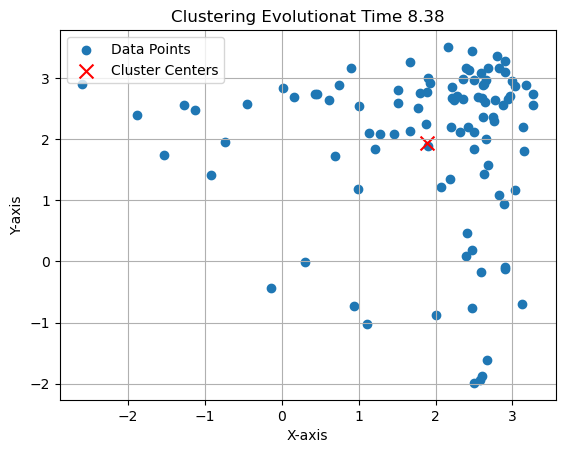

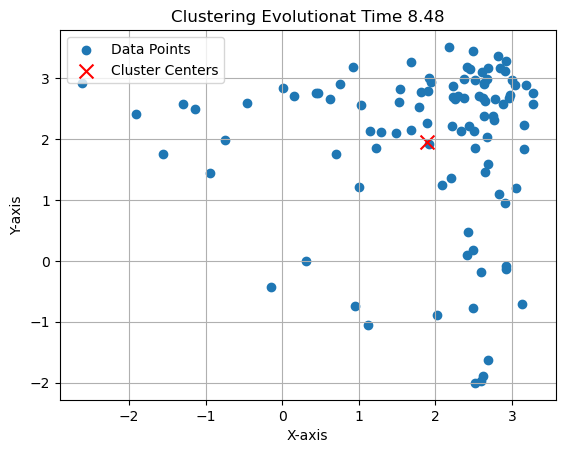

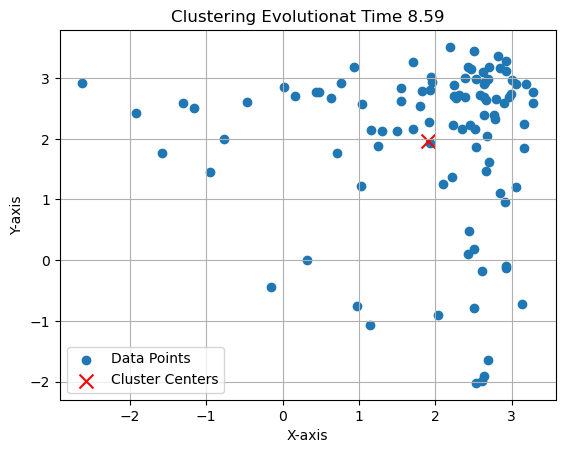

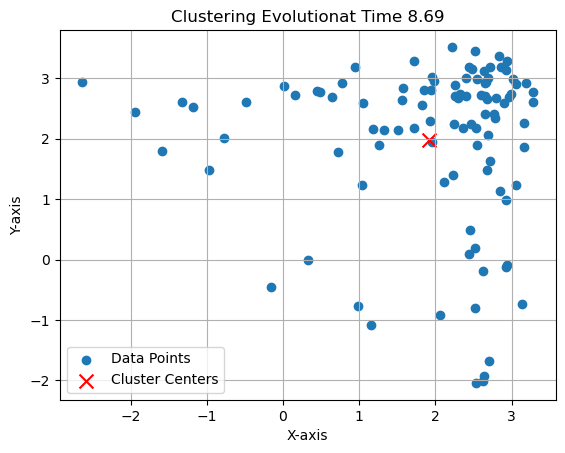

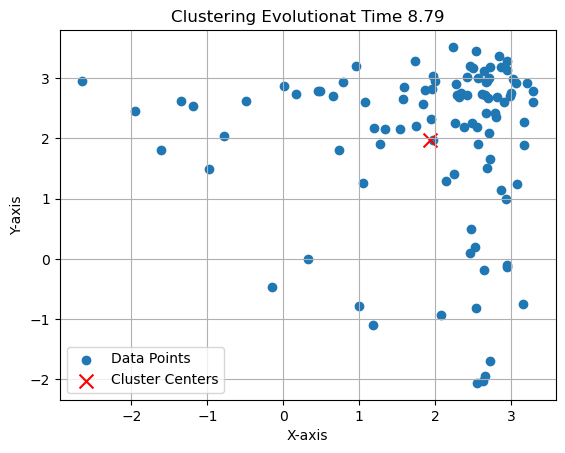

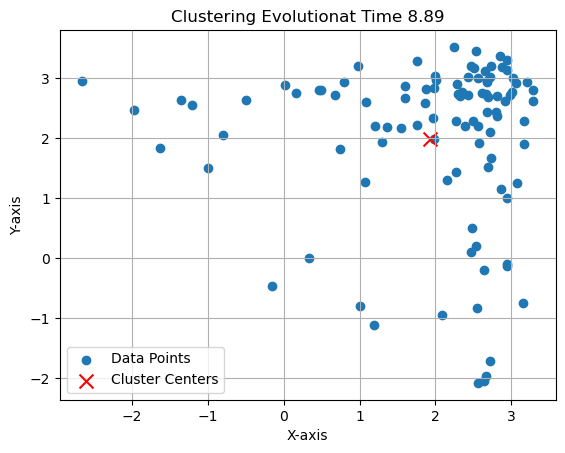

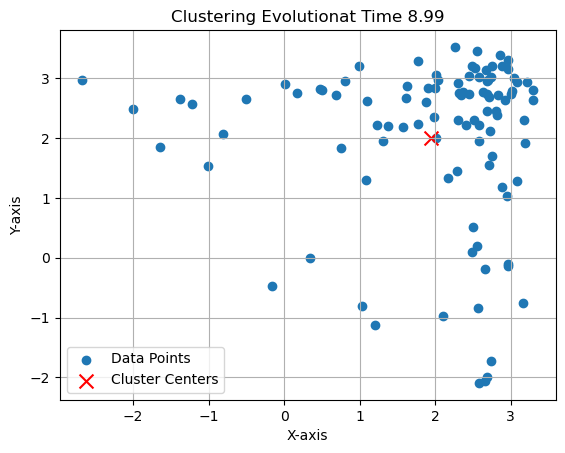

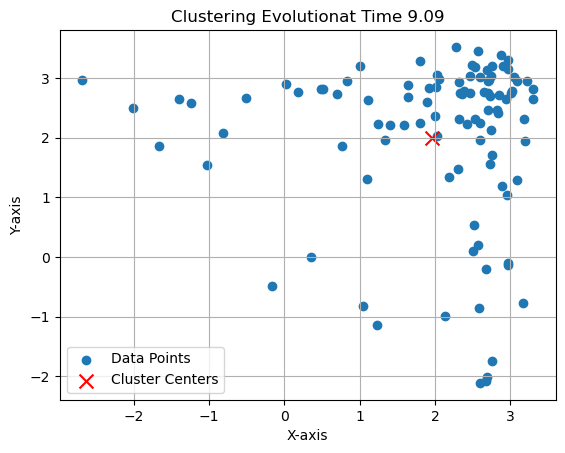

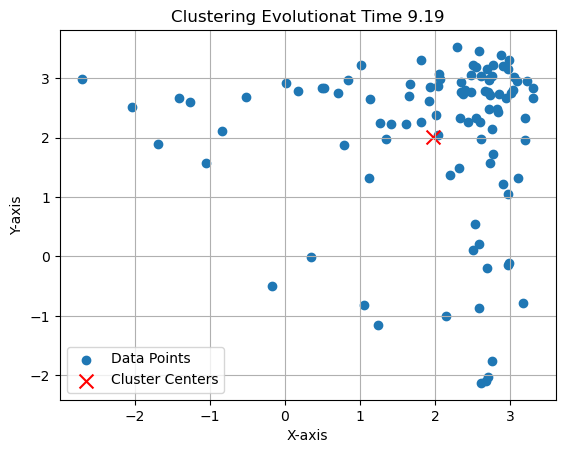

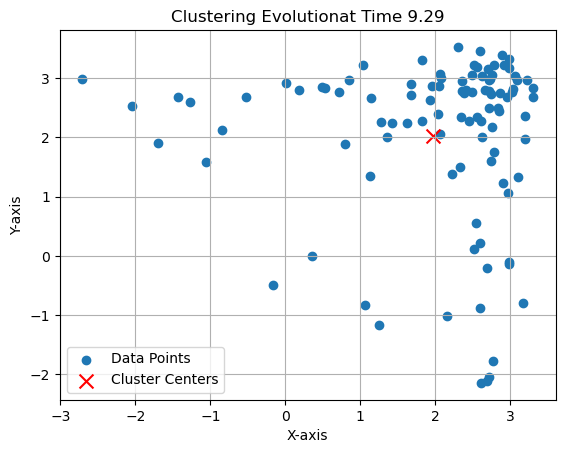

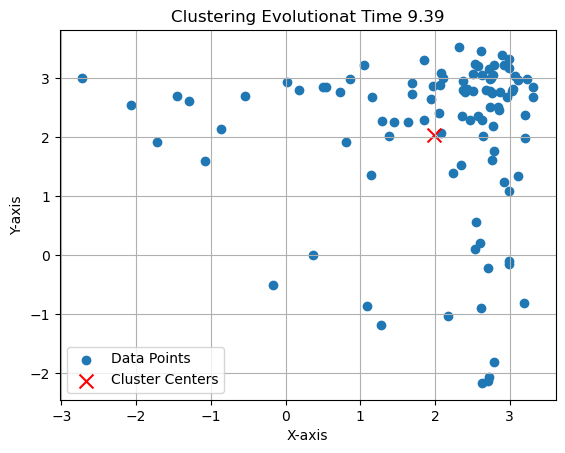

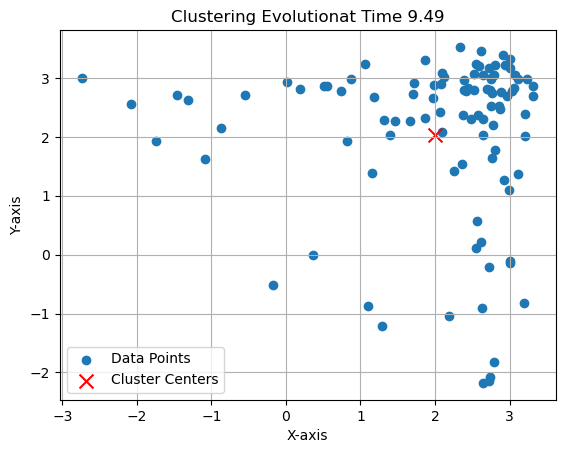

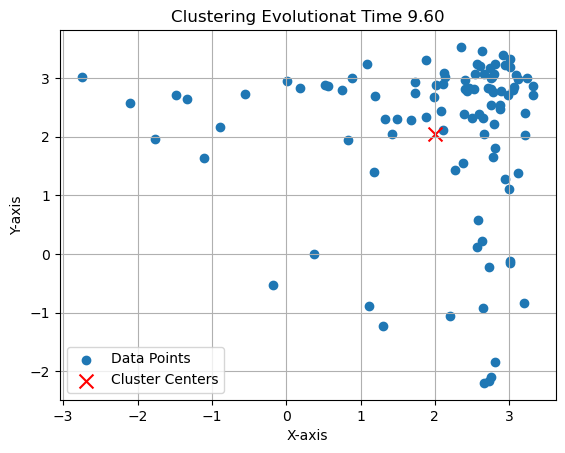

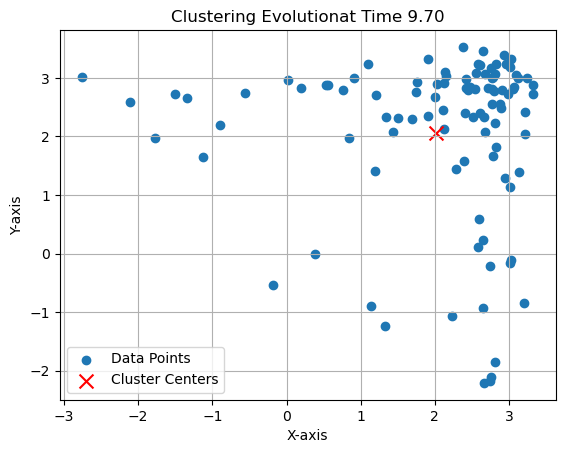

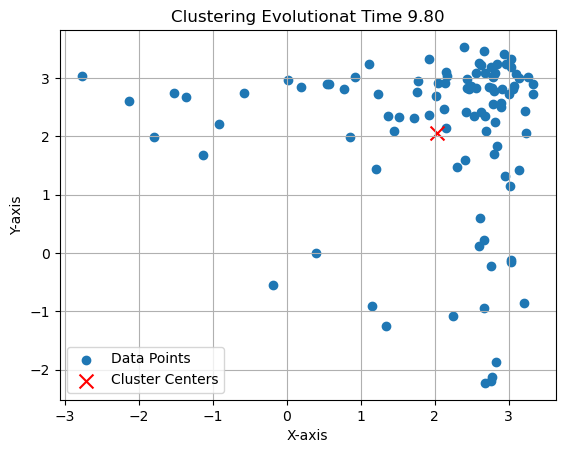

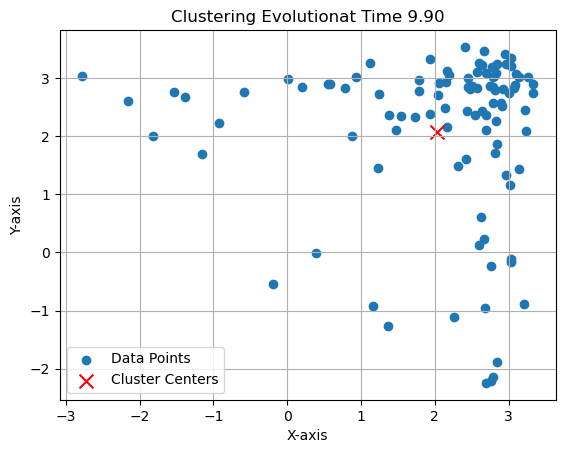

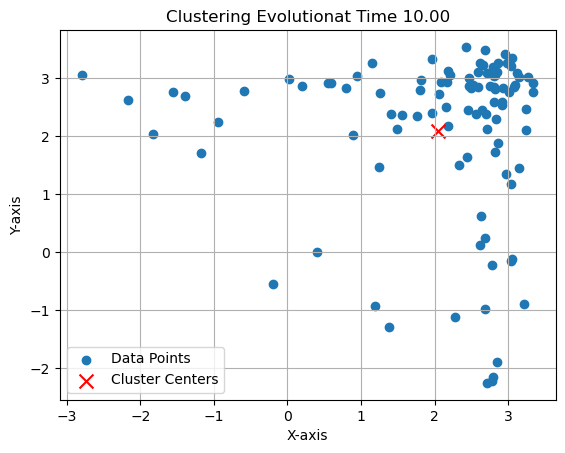

In [43]:
pert = 10e-10
m = 1
beta_final = 20
alpha = 1.05
Yt_list, Pt_yx_list = np.zeros((m,2,len(t))), np.zeros((N*m,m,len(t)))
for i in range (len(t)):
    Y_c, P_yx_c = clustering(X[:,:,i],m,pert,beta_final,alpha)
    Yt_list[:,:,i] = Y_c
    Pt_yx_list[:,:,i] = P_yx_c
    plt.scatter(X[:,0,i], X[:,1,i], label='Data Points')
    plt.scatter(Y_c[:, 0], Y_c[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
    plt.title(f"Clustering Evolutionat Time {t[i]:.2f}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.grid(True)
    plt.legend()
    plt.show()

In [44]:
# Create interpolation function
X_t = interpolate_data(X, t)
Yc_t = interpolate_data(Yt_list, t)
P_yx_t = interpolate_data(Pt_yx_list, t)
Xt_t = lambda t: X_t(min(t, 10))

## Clustered data at $t_0$

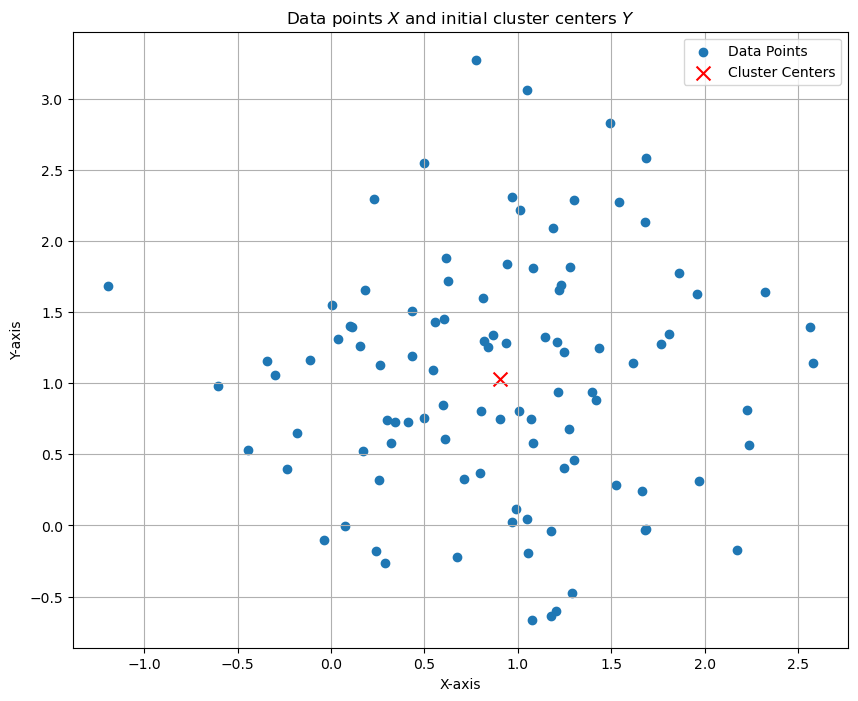

In [45]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X[:, 0, 0], X[:, 1, 0], label='Data Points')
plt.scatter(Yc_t(0)[:, 0], Yc_t(0)[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title("Data points $X$ and initial cluster centers $Y$")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.savefig('Data_t0.png', dpi=300, bbox_inches='tight')  # Saving the figure
plt.show()  

## Clustered data at $t_f$

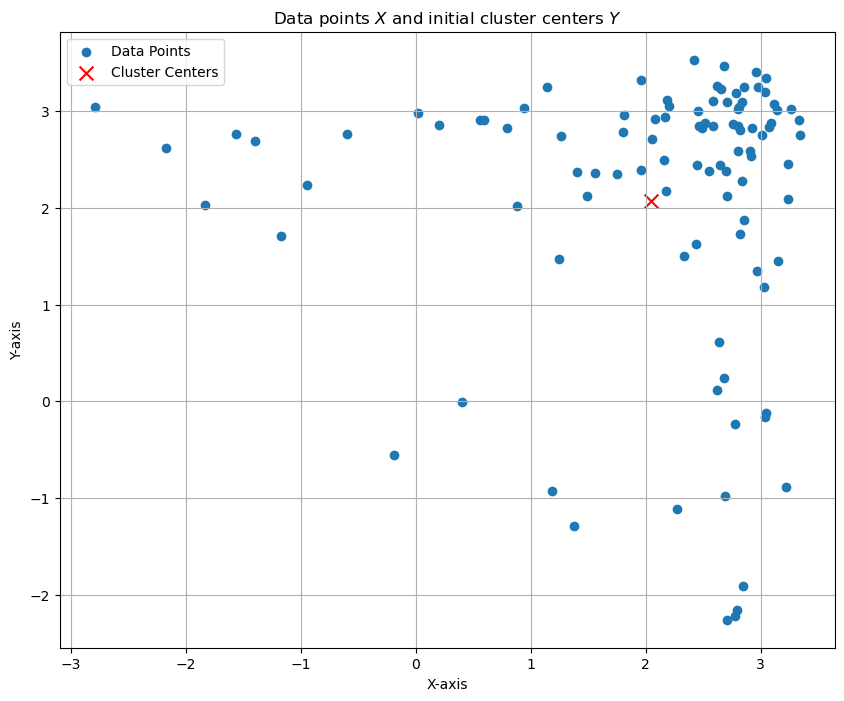

In [46]:
plt.figure(figsize=(10, 8))  # Set the size of the plot
plt.scatter(X[:, 0, -1], X[:, 1, -1], label='Data Points')
plt.scatter(Yc_t(10)[:, 0], Yc_t(10)[:, 1], color='red', marker='x', s=100, label='Cluster Centers')  # Plot cluster centers
plt.title("Data points $X$ and initial cluster centers $Y$")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.savefig('Data_tf.png', dpi=300, bbox_inches='tight')  # Saving the figure
plt.show()  

## Trajectory of cluster centers

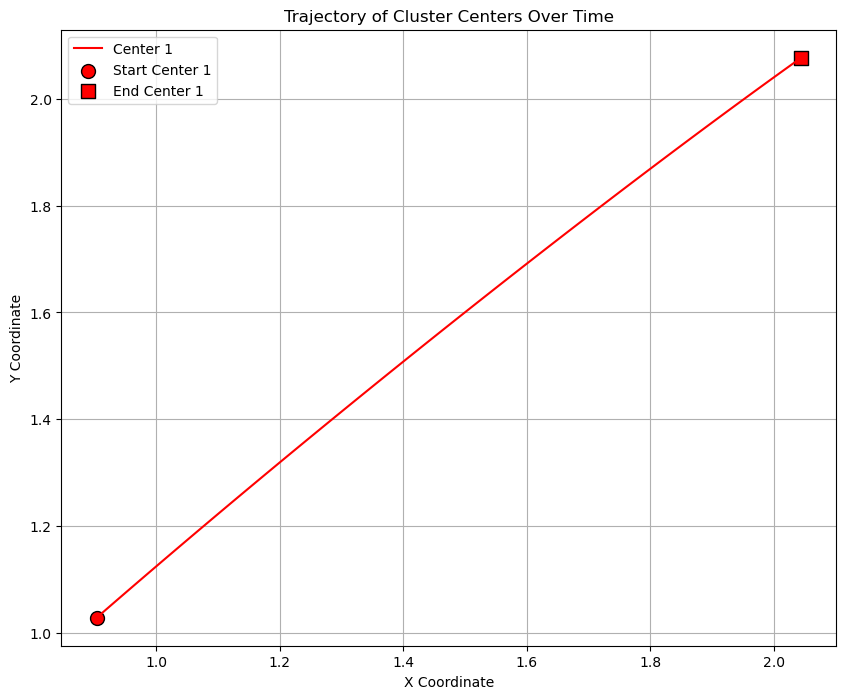

In [47]:
# Time points from 0 to 10 seconds at 0.5s intervals
times = np.linspace(0, 10, num=100)  # Use more points for smoother lines

# Prepare plot
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']  # Different color for each trajectory

# Plot trajectories and mark start/end points
for i in range(m):  # Assuming 3 cluster centers
    center_trajectory = np.array([Yc_t(t)[i] for t in times])  # Collect trajectory for center i
    plt.plot(center_trajectory[:, 0], center_trajectory[:, 1], label=f'Center {i+1}', color=colors[i])
    # Mark start and end points
    plt.scatter(center_trajectory[0, 0], center_trajectory[0, 1], color=colors[i], s=100, marker='o', edgecolors='k', label=f'Start Center {i+1}')
    plt.scatter(center_trajectory[-1, 0], center_trajectory[-1, 1], color=colors[i], s=100, marker='s', edgecolors='k', label=f'End Center {i+1}')

# Customize plot
plt.title('Trajectory of Cluster Centers Over Time')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

## Free energy function and its time derivative

In [48]:
def F_Fdot_clustering(X, Y, Dynamics_X, u_y, beta):
    N = X.shape[0]
    m = Y.shape[0]
    X_expanded = np.expand_dims(X, 1)  # Shape (N, 1, 2)
    Y_expanded = np.expand_dims(Y, 0)       # Shape (1, m, 2)
    distances = np.sqrt(np.sum((X_expanded - Y_expanded) ** 2, axis=2))
    distances_n = distances - np.min(distances, axis = 1).reshape(-1,1)
    Px = (1/N) * np.eye(N)
    P_yx = np.exp(-beta * distances_n)/(np.sum(np.exp(-beta * distances_n),axis = 1).reshape(-1,1))
    Py = (1/N) * np.diag(np.sum(Pt_yx_list[:,:,0],axis = 0))
    zeta = np.concatenate((X.T.flatten(),Y.T.flatten()), axis = 0)
    Pxy = Px @ P_yx
    P_xy = P_yx/(np.sum(P_yx, axis = 0).reshape(1,-1))
    Y_c = P_xy.T @ X
    F = (-1/beta/N) * np.sum(np.log(np.sum(np.exp(-beta * distances),axis = 1))) + (1/beta) * np.log(m)
    Gamma = np.block([[Px, np.zeros((N,N)), -Pxy, np.zeros((N,m))],
                 [np.zeros((N,N)), Px, np.zeros((N,m)), -Pxy],
                 [-Pxy.T, np.zeros((m,N)), Py, np.zeros((m,m))],
                 [np.zeros((m,N)), -Pxy.T, np.zeros((m,m)), Py]])
    X_dot = cp.vec(Dynamics_X(t,X).reshape(-1,2))
    f = cp.hstack((X_dot, u_y))
    Fdot = 2 * zeta.T @ Gamma @ f
    return F, Fdot, Y_c

In [49]:
F, Fdot, Y_center = F_Fdot_clustering(X_init, Yc_t(0), dynamics, np.ones(2*m), 0.00001)
F

0.9854699463019875

## Defining unsafe region

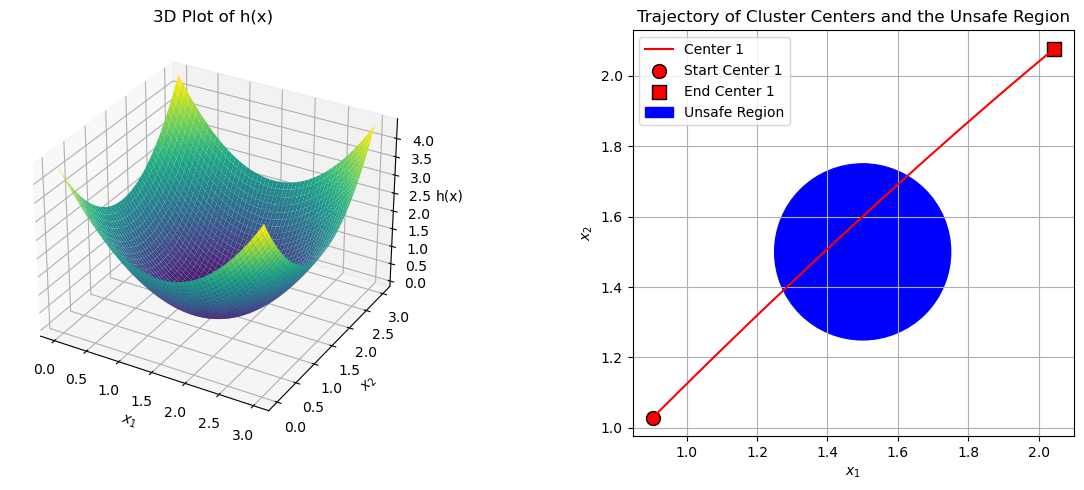

In [50]:
# Function definition
def H(x1, x2):
    return ((x1 - 1.5)**2 + (x2 - 1.5)**2 - 1/16)

# Generate mesh grid
x = np.linspace(0, 3, 400)
y = np.linspace(0, 3, 400)
X, Y = np.meshgrid(x, y)
Z = H(X, Y)

# Create a figure with subplots
fig = plt.figure(figsize=(13, 5))

# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax1.set_title('3D Plot of h(x)')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('h(x)')

# Contour plot
ax2 = fig.add_subplot(122)
# Plot trajectories and mark start/end points
for i in range(m):  # Assuming 3 cluster centers
    center_trajectory = np.array([Yc_t(t)[i] for t in times])  # Collect trajectory for center i
    ax2.plot(center_trajectory[:, 0], center_trajectory[:, 1], label=f'Center {i+1}', color=colors[i])
    # Mark start and end points
    ax2.scatter(center_trajectory[0, 0], center_trajectory[0, 1], color=colors[i], s=100, marker='o', edgecolors='k', label=f'Start Center {i+1}')
    ax2.scatter(center_trajectory[-1, 0], center_trajectory[-1, 1], color=colors[i], s=100, marker='s', edgecolors='k', label=f'End Center {i+1}')
circle = Circle((1.5, 1.5), 0.25, color='blue', fill=True, linewidth=1, label = 'Unsafe Region')  # Define the circle
ax2.add_patch(circle)  # Add the circle to the plot
ax2.set_aspect('equal', 'box')  # Ensures the circle isn't distorted
ax2.set_title('Trajectory of Cluster Centers and the Unsafe Region')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.legend()
ax2.grid(True)

# Overall adjustments
plt.tight_layout()
plt.savefig('CBF.png', dpi=300, bbox_inches='tight')  # Saving the figure
plt.show()

In [51]:
def h_hdot(Y, u_y):
    h = np.sum((Y - np.array([[1.5, 1.5]]))**2, axis = 1) - (0.25)**2
    temp = cp.multiply(2 * Y.T.flatten() -  3, u_y).reshape((-1,2), order = 'F')
    hdot = cp.sum(temp, axis = 1)
    return h, hdot

## Defining control signal

In [52]:
# Decision variables 
m = 1
Y0 = np.zeros((m,2))
beta = 20
z = cp.Variable(2 * m + 1)
u_y = z[0 : 2 * m]
nu = z[-1]
rate = 1

# Objective: minimize the norm of u_y
objective = cp.Minimize(cp.sum_squares(u_y))

# Define constraints
F , Fdot, Y_center = F_Fdot_clustering(X_init, Y0, dynamics, u_y, beta)
h, hdot = h_hdot(Y0, u_y)
constraints = [Fdot <=  - nu * F, nu >= rate, hdot >= - 20 * h]

# Define the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
result = problem.solve()

# Check the status of the problem
print("Status:", problem.status)
print("Optimal value:", result)

# Access the values of the decision variables
u_y_values = u_y.value
nu_value = nu.value

print("Optimal control (u_y):", u_y_values)
print("Optimal nu:", nu_value)

Status: optimal
Optimal value: 0.6535465222578002
Optimal control (u_y): [0.5334878  0.60740208]
Optimal nu: 0.9999999999999999


In [53]:
def control (X, Y, beta, X_dynamics, rate, alpha, p):

    # Decision variables 
    m = Y.shape[0]
    eps = 0.01
    z = cp.Variable(2 * m + 1)
    u_y = z[0 : 2 * m]
    nu = z[-1]

    # Objective: minimize the norm of u_y
    objective = cp.Minimize(cp.sum_squares(u_y))

    # Define constraints
    F , Fdot, Y_center = F_Fdot_clustering(X, Y, X_dynamics, u_y, beta)
    constraints = [Fdot <=  - nu * F, nu >= rate]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()
    
    if u_y.value is None:
        U = np.zeros((m,2))
    else:
        U = u_y.value.reshape(-1, 2, order='F')  # Reshape the result into the expected format
        for k in range(m):
            if np.linalg.norm(Y_center[k,:] - Y[k,:]) <= eps:
                U[k,:] = np.zeros(2)
    return U

In [54]:
def safe_control (X, Y, beta, X_dynamics, rate, alpha, p):

    # Decision variables 
    m = Y.shape[0]
    z = cp.Variable(2 * m + 2)
    u_y = z[0 : 2 * m]
    nu = z[-2]
    delta = z[-1]

    # Objective: minimize the norm of u_y
    objective = cp.Minimize(0.5 * cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot = F_Fdot_clustering(X, Y, X_dynamics, u_y, beta)
    h, hdot = h_hdot(Y, u_y)
    constraints = [Fdot <=  - nu * F + delta, nu >= rate, hdot >= - alpha * h]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()
    
    if u_y.value is None:
        U = np.zeros((m,2))
    else:
        U = u_y.value.reshape(-1, 2, order='F')  # Reshape the result into the expected format

    return U

In [55]:
def control_dir (X, Y, beta, X_dynamics, rate, alpha, p):

    # Decision variables 
    m = Y.shape[0]
    z = cp.Variable(2 * m + 1)
    u_y = z[0 : 2 * m]
    nu = z[-1]

    # Objective: minimize the norm of u_y
    objective = cp.Minimize(cp.sum_squares(u_y))

    # Define constraints
    F , Fdot, Y_center = F_Fdot_clustering(X, Y, X_dynamics, u_y, beta)
    constraints = [Fdot <=  - nu * F, nu >= rate]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()
    
    if u_y.value is None:
        U = np.zeros((m,2))
    else:
        U = u_y.value.reshape(-1, 2, order='F')  # Reshape the result into the expected format

    return U/(np.linalg.norm(U, axis = 1)).reshape(-1,1)

In [56]:
def safe_control_dir (X, Y, beta, X_dynamics, rate, alpha, p):

    # Decision variables 
    m = Y.shape[0]
    eps = 0.01
    z = cp.Variable(2 * m + 1)
    u_y = z[0 : 2 * m]
    delta = z[-1]

    # Objective: minimize the norm of u_y
    objective = cp.Minimize(0.5 * cp.sum_squares(u_y) + p * delta**2)

    # Define constraints
    F , Fdot, Y_center = F_Fdot_clustering(X, Y, X_dynamics, u_y, beta)
    h, hdot = h_hdot(Y, u_y)
    constraints = [Fdot <=  - rate * F + delta, hdot >= - alpha * h]

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve(verbose=0)
    
    if u_y.value is None:
        U = np.zeros((m,2))
    else:
        U = u_y.value.reshape(-1, 2, order='F')  # Reshape the result into the expected format
        U_dir = U/(np.linalg.norm(U, axis = 1)).reshape(-1,1)
        for k in range(m):
            if np.linalg.norm(Y_center[k,:] - Y[k,:]) <= eps:
                U_dir[k,:] = np.zeros(2)
                
    return U_dir, delta.value

In [57]:
def plot_resources_and_controls(Yc_t, Yr_t, control):

    plt.figure(figsize=(10, 8))

    # Scatter plot for resource locations
    plt.scatter(Yr_t[:, 0], Yr_t[:, 1], color='blue', label='Resource Locations', alpha=0.6, edgecolor='black')

    # Draw arrows for control directions
    for i in range(len(Yr_t)):
        plt.arrow(Yr_t[i, 0], Yr_t[i, 1], control[i, 0], control[i, 1], head_width=0.05, head_length=0.05, fc='red', ec='red')

    # Scatter plot for cluster centers
    plt.scatter(Yc_t[:, 0], Yc_t[:, 1], color='green', label='Cluster Centers', marker='s', alpha=0.6, edgecolor='black')

    # Adding title and labels
    plt.title('Resource Movements and Cluster Centers')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensures that unit lengths are the same in all directions
    # plt.savefig('control_dir.png', dpi=300)  # Saving the figure
    return plt

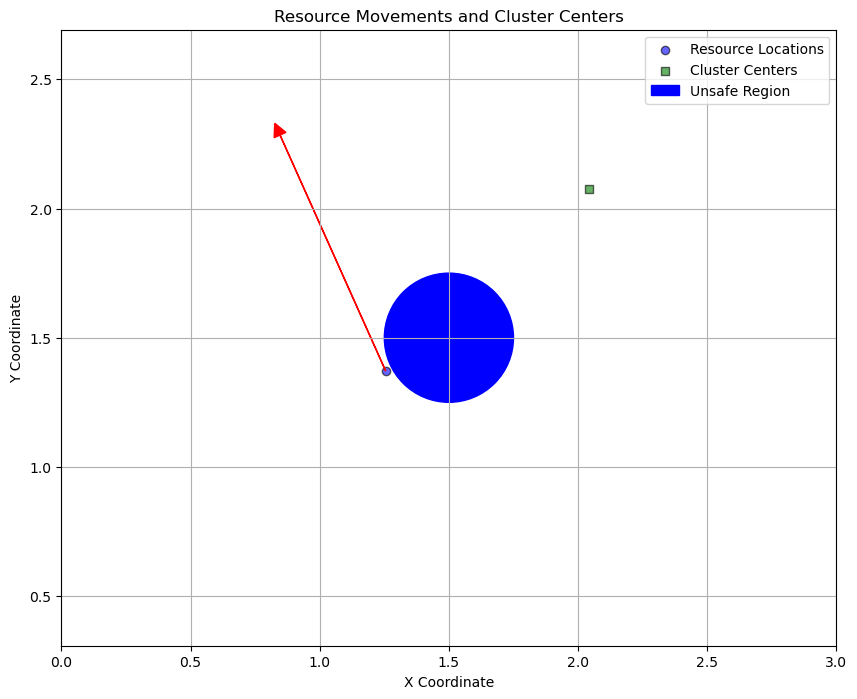

In [58]:
t = 10
Y_init = Yc_t(3)
# Y_init = np.array([[0.5, 2]])
rate = 1
alpha = 10
p = 100
u_t, delta = safe_control_dir(Xt_t(t), Y_init, 20, dynamics, rate, alpha, p)
plot = plot_resources_and_controls(Yc_t(t), Y_init, u_t)
circle = Circle((1.5, 1.5), 0.25, color='blue', fill=True, linewidth=1, label = 'Unsafe Region')  # Define the circle
# Get current axes, add the circle to it
ax = plot.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the axes
# Optional: set limits and labels
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.legend()
# plot.savefig('control_dir.png', dpi=300)  # Saving the figure
plot.show()

## Numerical Simulation

In [59]:
# Simulation parameters
dt = 0.1  # Time step
T = 100  # Total time
pert = 0.1
rate = 1
time = np.arange(0, T, dt)  # Time vector
alpha = 5
p = 100
Y_init = Yc_t(0) + pert * np.random.rand(m,2)
# Y_init = np.array([[0.5, 2]])
# Function to simulate Yr trajectory
def simulate_trajectory(Y_init, X_at_t, dt, T, rate, alpha, p):
    
    Yr = np.zeros((m,2,len(time)))  # Array to hold Yr values over time
    Yr[:,:,0] = Y_init  # Set initial condition
    
    # u_prev = np.zeros((m,2))
    for i in range(1, len(time)):
        t = time[i-1]  # Current time point
        u_t, delta = safe_control_dir(X_at_t(t), Yr[:,:,i-1], 20, dynamics, rate, alpha, p)  # Control output at time t
        Yr[:,:,i] = Yr[:,:,i-1] + (u_t/10) * dt  # Update Yr based on control output
        # u_prev = u_t
        
    return Yr

# Run the simulation
Yr_trajectory = simulate_trajectory(Y_init, Xt_t, dt, T, rate, alpha, p)

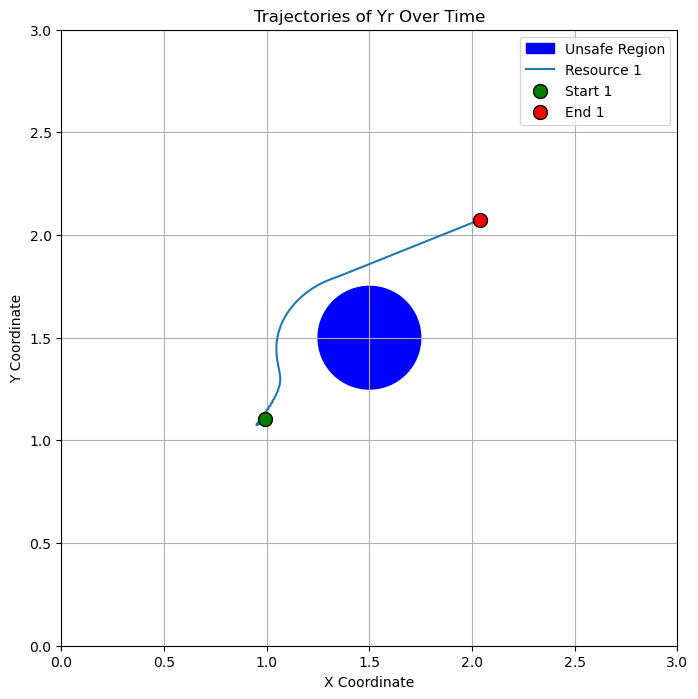

In [60]:
# Plotting the results
plt.figure(figsize=(10, 8))
circle = Circle((1.5, 1.5), 0.25, color='blue', fill=True, linewidth=1, label = 'Unsafe Region')  # Define the circle
# Get current axes, add the circle to it
ax = plot.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the axes
ax.set_aspect('equal', 'box')  # Ensures the circle isn't distorted
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.legend()

for i in range(m):
    plt.plot(Yr_trajectory[i, 0, :], Yr_trajectory[i, 1, :], label=f'Resource {i+1}')
    
    # Mark the starting point (first time step)
    plt.scatter(Yr_trajectory[i, 0, 0], Yr_trajectory[i, 1, 0], color='green', s=100, edgecolor='black', label=f'Start {i+1}', zorder=5)
    
    # Mark the ending point (last time step)
    plt.scatter(Yr_trajectory[i, 0, -1], Yr_trajectory[i, 1, -1], color='red', s=100, edgecolor='black', label=f'End {i+1}', zorder=5)    
    
plt.title('Trajectories of Yr Over Time')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

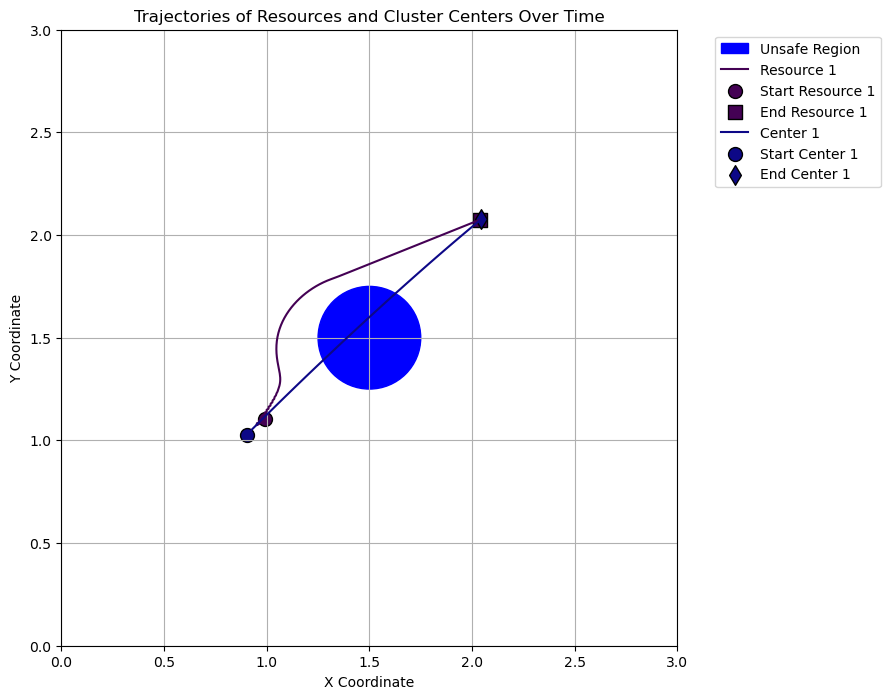

In [61]:
# Plotting configuration
plt.figure(figsize=(10, 8))
circle = Circle((1.5, 1.5), 0.25, color='blue', fill=True, linewidth=1, label = 'Unsafe Region')  # Define the circle
# Get current axes, add the circle to it
ax = plot.gca()  # Get current axes
ax.add_patch(circle)  # Add the circle to the axes
ax.set_aspect('equal', 'box')  # Ensures the circle isn't distorted
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.legend()

resource_colors = plt.cm.viridis(np.linspace(0, 0.5, m))  # Different color for each resource trajectory

for i in range(m):
    plt.plot(Yr_trajectory[i, 0, :], Yr_trajectory[i, 1, :], label=f'Resource {i+1}', color=resource_colors[i])
    plt.scatter(Yr_trajectory[i, 0, 0], Yr_trajectory[i, 1, 0], color=resource_colors[i], s=100, marker='o', edgecolors='k', label=f'Start Resource {i+1}')
    plt.scatter(Yr_trajectory[i, 0, -1], Yr_trajectory[i, 1, -1], color=resource_colors[i], s=100, marker='s', edgecolors='k', label=f'End Resource {i+1}')

# Plot cluster center trajectories
n_centers = 3  # Assuming 3 cluster centers
center_colors = plt.cm.plasma(np.linspace(0, 0.5, n_centers))  # Different color for each cluster center

for i in range(m):
    center_trajectory = np.array([Yc_t(t)[i] for t in times])  # Collect trajectory for center i
    plt.plot(center_trajectory[:, 0], center_trajectory[:, 1], label=f'Center {i+1}', color=center_colors[i])
    plt.scatter(center_trajectory[0, 0], center_trajectory[0, 1], color=center_colors[i], s=100, marker='o', edgecolors='k', label=f'Start Center {i+1}')
    plt.scatter(center_trajectory[-1, 0], center_trajectory[-1, 1], color=center_colors[i], s=100, marker='d', edgecolors='k', label=f'End Center {i+1}')

# Customize plot
plt.title('Trajectories of Resources and Cluster Centers Over Time')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend out of the plot
plt.grid(True)
# Save the figure
plt.savefig('Resource_traj_small_a.png', bbox_inches='tight', dpi = 300)
plt.show()

In [62]:
Yc_t(10)

array([[2.04405947, 2.07680805]])

In [63]:
Yr_trajectory[:,:,-1]

array([[2.03715601, 2.07404171]])